# LDLR Prime Editing Saturation Mutagenesis Screen

#### Import packages

In [920]:
from os.path import exists
from typing import Union, List, Mapping, Tuple, Optional
from functools import partial
from typeguard import typechecked
from enum import Enum
import numpy as np
import pandas as pd

#### Import hg38 reference

In [2]:
%%time

from Bio import SeqIO
from Bio.Seq import Seq

valid_chromosomes = ["chr19"]

# Load the chromosome that contains region, so we don't have to load whole-genome. 
inFile = open('/data/molpath/genomes/hg38/hg38.fa','r')
hg38_chromosome_sequences = {}
for record in SeqIO.parse(inFile,'fasta'): 
    if record.id in valid_chromosomes:
        print(record.id)
        hg38_chromosome_sequences.update({record.id:record.seq}) 

chr19
CPU times: user 21.5 s, sys: 11.6 s, total: 33.1 s
Wall time: 1min 58s


#### Import GENCODE GRCH38 annotation file

In [4]:
# Download the GENCODE annotation file
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.annotation.gtf.gz gencode.v40.annotation.gtf.gz
    # Preview of the GENCODE annotation file
!zcat gencode.v40.annotation.gtf.gz | head -n 10

--2022-12-11 16:04:34--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48043727 (46M) [application/x-gzip]
Saving to: ‘gencode.v40.annotation.gtf.gz.4’

100%[======================================>] 48,043,727   704KB/s   in 87s    

2022-12-11 16:06:02 (542 KB/s) - ‘gencode.v40.annotation.gtf.gz.4’ saved [48043727/48043727]

--2022-12-11 16:06:02--  http://gencode.v40.annotation.gtf.gz/
Resolving gencode.v40.annotation.gtf.gz (gencode.v40.annotation.gtf.gz)... failed: Name or service not known.
wget: unable to resolve host address ‘gencode.v40.annotation.gtf.gz’
FINISHED --2022-12-11 16:06:02--
Total wall clock time: 1m 28s
Downloaded: 1 files, 46M in 1m 27s (542 KB/s)
##description: evidence-based annotation of the human genome (GRCh38), versio

#### Process annotation file - specifically extracting gene name and transcript ID

In [5]:
# Read in the GENCODE annotation file as a Pandas dataframe
gencode_annotations = pd.read_table("gencode.v40.annotation.gtf.gz", compression='gzip', comment='#', header=None)

# Preview of the GENCODE dataframe 
gencode_annotations.head()

# Helper function: retrieve the gene_name from the info column (number 8) since we need to select for gene_name==ZNF410
def get_genename_from_info(info):
    gene_id_start = info.find("gene_name") + len("gene_name") + 2
    info = info[gene_id_start:]
    gene_id_end = info.find(";")-1
    return info[:gene_id_end]

# Create new column with the extracted gene_name using the function above
gencode_annotations[9] = gencode_annotations.iloc[:, 8].apply(get_genename_from_info)

# Helper function: retrieve the transcript_id from the info column (number 8) since we need to select for canonical transcript
def get_transcriptid_from_info(info):
    transcript_id_start = info.find("transcript_id") + len("transcript_id") + 2
    info = info[transcript_id_start:]
    transcript_id_end = info.find(";")-1
    return info[:transcript_id_end]

# Create new column with the extracted gene_name using the function above
gencode_annotations[10] = gencode_annotations.iloc[:, 8].apply(get_transcriptid_from_info)

#### View LDLR gene annotation

In [6]:
gencode_annotations_ldlr = gencode_annotations[gencode_annotations[9] == "LDLR"]

gencode_annotations_ldlr_gene_level = gencode_annotations_ldlr[gencode_annotations_ldlr[2]=="gene"]
display(gencode_annotations_ldlr_gene_level)

,0,1,2,3,4,5,6,7,8,9,10
2840460,chr19,HAVANA,gene,11089462,11133820,.,+,.,"gene_id ""ENSG00000130164.14""; gene_type ""prote...",LDLR,0000130164.14


#### View LDLR canonical transcript ID annotation

ID from https://useast.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000130164;r=19:11089462-11133820

In [7]:
ldlr_canonical_transcript_id = "ENST00000558518.6"
gencode_annotations_ldlr_canonical = gencode_annotations_ldlr[gencode_annotations_ldlr[10] == ldlr_canonical_transcript_id]
gencode_annotations_ldlr_canonical_transcript = gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "transcript"]
display(gencode_annotations_ldlr_canonical_transcript)

,0,1,2,3,4,5,6,7,8,9,10
2840622,chr19,HAVANA,transcript,11089463,11133820,.,+,.,"gene_id ""ENSG00000130164.14""; transcript_id ""E...",LDLR,ENST00000558518.6


#### Retrieve CDS and exon coordinates of LDLR

In [8]:
gencode_annotations_ldlr_canonical_CDS = gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "CDS"]

gencode_annotations_ldlr_canonical_exon = gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "exon"]
gencode_annotations_ldlr_canonical_exon_sorted = gencode_annotations_ldlr_canonical_exon.sort_values(3, ascending=gencode_annotations_ldlr_canonical_exon.iloc[0, 6] == "+")
gencode_annotations_ldlr_canonical_exon_sorted.iloc[:, 2] = gencode_annotations_ldlr_canonical_exon_sorted.iloc[:, 2] + ["_" + str(index) for index in range(1, gencode_annotations_ldlr_canonical_exon_sorted.shape[0]+1)] # Add labels

#### Rerieve splice-site targetting sequences

In [10]:
'''
    Splice-site targetting sequences
'''
strand = gencode_annotations_ldlr_canonical_exon_sorted.iloc[0, 6]
splice_sites = []
for row_i in range(0, gencode_annotations_ldlr_canonical_exon_sorted.shape[0]-1):
    if strand == "-":
        donor_row = pd.Series(["chr19", "intron_"+str(row_i+1)+"_donor",gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 3]-20, gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 3]])
        acceptor_row = pd.Series(["chr19", "intron_"+str(row_i+1)+"_acceptor",gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 4], gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 4]+20])
        splice_sites.append(donor_row)
        splice_sites.append(acceptor_row)
    elif strand == "+":
        donor_row = pd.Series(["chr19", "intron_"+str(row_i+1)+"_donor",gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 4], gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 4]+20])
        acceptor_row = pd.Series(["chr19", "intron_"+str(row_i+1)+"_acceptor",gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 3]-20, gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 3]])
        splice_sites.append(donor_row)
        splice_sites.append(acceptor_row)
gencode_annotations_ldlr_canonical_ss_sorted = pd.DataFrame(splice_sites)

#### Rerieve intron sequences

In [11]:
#gencode_annotations_cxcr4_canonical_intron_sorted = 

strand = gencode_annotations_ldlr_canonical_exon_sorted.iloc[0, 6]
introns = []
for row_i in range(0, gencode_annotations_ldlr_canonical_exon_sorted.shape[0]-1):
    intron_row = None
    if strand == "-":
        intron_row = pd.Series(["chr19", "intron_"+str(row_i+1),gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 4], gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 3]])
    elif strand == "+":
        intron_row = pd.Series(["chr19", "intron_"+str(row_i+1), gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i, 4], gencode_annotations_ldlr_canonical_exon_sorted.iloc[row_i+1, 3]])
    introns.append(intron_row)
    
gencode_annotations_ldlr_canonical_introns_sorted = pd.DataFrame(introns)

#### Rerieve UTR sequences

In [12]:
gencode_annotations_ldlr_canonical_UTR = gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "UTR"]

gencode_annotations_ldlr_canonical_UTR_sorted = gencode_annotations_ldlr_canonical_UTR.sort_values(3, ascending=gencode_annotations_ldlr_canonical_UTR.iloc[0, 7] == "+")
gencode_annotations_ldlr_canonical_UTR_sorted.iloc[0,2] = "5'UTR"
gencode_annotations_ldlr_canonical_UTR_sorted.iloc[1,2] = "3'UTR"

#### Rerieve transcript sequences

In [13]:
gencode_annotations_ldlr_canonical_start =  gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "start_codon"]
gencode_annotations_ldlr_canonical_stop =  gencode_annotations_ldlr_canonical[gencode_annotations_ldlr_canonical[2] == "stop_codon"]

In [14]:
'''
    Get relevant hg38 coordinates 
'''
transcript_chr = gencode_annotations_ldlr_canonical_transcript.iloc[0,0]
transcript_start = gencode_annotations_ldlr_canonical_transcript.iloc[0,3]
transcript_stop = gencode_annotations_ldlr_canonical_transcript.iloc[0,4]
transcript_strand = gencode_annotations_ldlr_canonical_transcript.iloc[0,6]

In [15]:
nascent_transcript_sequence = hg38_chromosome_sequences["chr19"][transcript_start:transcript_stop]

In [16]:
# Annotation variables
'''
    gencode_annotations_ldlr_canonical_CDS
    gencode_annotations_ldlr_canonical
    gencode_annotations_ldlr_canonical_transcript
    gencode_annotations_ldlr_canonical_exon_sorted
    gencode_annotations_ldlr_canonical_ss_sorted
    gencode_annotations_ldlr_canonical_introns_sorted
    gencode_annotations_ldlr_canonical_UTR
    gencode_annotations_ldlr_canonical_start
    gencode_annotations_ldlr_canonical_stop
'''

'\n    gencode_annotations_ldlr_canonical_CDS\n    gencode_annotations_ldlr_canonical\n    gencode_annotations_ldlr_canonical_transcript\n    gencode_annotations_ldlr_canonical_exon_sorted\n    gencode_annotations_ldlr_canonical_ss_sorted\n    gencode_annotations_ldlr_canonical_introns_sorted\n    gencode_annotations_ldlr_canonical_UTR\n    gencode_annotations_ldlr_canonical_start\n    gencode_annotations_ldlr_canonical_stop\n'

In [17]:
# Test exon 1 sequence
exon1_coding_sequence = hg38_chromosome_sequences["chr19"][gencode_annotations_ldlr_canonical_start.iloc[0, 3]-1:gencode_annotations_ldlr_canonical_exon_sorted.iloc[0, 4]]

In [18]:
str(exon1_coding_sequence)

'ATGGGGCCCTGGGGCTGGAAATTGCGCTGGACCGTCGCCTTGCTCCTCGCCGCGGCGGGGACTGCAG'

In [19]:
# Get coordinates for all exons

coding_exon_sequences_list = []
previous_nt_end = 0
previous_codon_end = 0

coding_start_coordinate = gencode_annotations_ldlr_canonical_start.iloc[0, 3]-1
coding_end_coordinate = gencode_annotations_ldlr_canonical_stop.iloc[0, 4]
for i in range(0, gencode_annotations_ldlr_canonical_exon_sorted.shape[0]):
    start_coordinate = gencode_annotations_ldlr_canonical_exon_sorted.iloc[i, 3]-1
    end_coordinate = gencode_annotations_ldlr_canonical_exon_sorted.iloc[i, 4]
    if i == 0:
        start_coordinate = coding_start_coordinate
    elif i == gencode_annotations_ldlr_canonical_exon_sorted.shape[0] - 1:
        end_coordinate = coding_end_coordinate
    
    sequence = hg38_chromosome_sequences["chr19"][start_coordinate:end_coordinate]
    
    start_nt_index = previous_nt_end
    end_nt_index = start_nt_index + len(sequence)
    previous_nt_end = end_nt_index
    
    # This is to determine if the last codon is complete, if not, indexing should reflect.
    codon_completed = len(sequence) % 3 == 0
    print(codon_completed)
    
    start_codon_index = previous_codon_end 
    end_codon_index = start_codon_index + (len(sequence)/3)
    previous_codon_end = end_codon_index
    
    if not codon_completed:
        previous_codon_end = previous_codon_end - 1
    
    coding_exon_sequences_list.append((sequence, (start_coordinate, end_coordinate), (start_nt_index, end_nt_index), (start_codon_index, end_codon_index)))

# NOTE: 10/5/2022: There may be an off-by-one error in the indexing 

False
True
True
True
True
True
True
True
False
True
False
False
False
True
True
True
False
True


In [20]:
complete_coding_sequence = "".join([str(sequence_tuple[0]) for sequence_tuple in coding_exon_sequences_list])

In [21]:
assert len(complete_coding_sequence) % 3 == 0 # Assert divisible by 3

In [22]:
nascent_transcript_sequence

Seq('TGCAATCGCGGGAAGCCAGGGTTTCCAGCTAGGACACAGCAGGTCGTGATCCGG...CAA')


#### Define helper functions and classes 

In [23]:
import dataclasses
import pydantic

# Python class of a Codon
@dataclasses.dataclass
class Codon:
    sequence_codon_index:int
    genome_index_start: int
    genome_index_stop: int
    codon_sequence: Union[Seq, str]
    
class Config:
    arbitrary_types_allowed = True

# Python function to split an ORF sequence into sets of codons
@pydantic.validate_arguments(config=Config)
def split_into_codons(sequence: Union[Seq, str], codon_indices=None) -> List[Codon]:
    codon_set = []
    for codon_index, genomic_index in enumerate(range(int(len(sequence)/3))):
        codon = sequence[genomic_index*3:genomic_index*3+3]
        codon_set.append(Codon(sequence_codon_index=genomic_index, genome_index_start=genomic_index*3, genome_index_stop=genomic_index*3+3, codon_sequence=codon))
    return codon_set

# Class for containing codon set
class CodingTilingSequence(pydantic.BaseModel):
    class Config:
        arbitrary_types_allowed = True
        
    complete_sequence: Union[Seq, str]
    coding_coordinates: Tuple[int,int]
    tiling_coordinates: Tuple[int,int]
        
    
    coding_codon_set: List[Codon]
    tiled_codon_set: List[Codon]
    orf_position: int

In [24]:
# Split coding sequence into codons
complete_codon_set = split_into_codons(complete_coding_sequence)

In [25]:
# Define dictionary mapping codons to amino acid letter
dna_codon_map: Mapping[str, str] = {
    # 'M' - START, '_' - STOP
    "GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D",
    "GAA": "E", "GAG": "E",
    "TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "CAT": "H", "CAC": "H",
    "ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K",
    "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M",
    "AAT": "N", "AAC": "N",
    "CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R",
    "TCT": "S", "TCC": "S", "TCA": "S", "TCG": "S", "AGT": "S", "AGC": "S",
    "ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V",
    "TGG": "W",
    "TAT": "Y", "TAC": "Y",
    "TAA": "_", "TAG": "_", "TGA": "_"
}


In [26]:
# Codon frequencies based on Human table from GenScript https://www.genscript.com/tools/codon-frequency-table
# TODO: Double check that all frequencies and codons are accurate
# Originally to be used to select codon that is most frequent, however since all codons for a letter will be included in initial pegRNA set, this dictionary is not used
dna_codon_frequency_map: Mapping[str, List[Tuple[str, float]]]= {
    "F": [("TTT", 0.45), ("TTC", 0.55)],
    "L": [("TTA", 0.07), ("TTG", 0.13), ("CTT", 0.13), ("CTC", 0.20), ("CTA", 0.07), ("CTG", 0.41)],
    "Y": [("TAT", 0.43), ("TAC", 0.57)],
    "_": [("TAA", 0.28), ("TAG", 0.20,), ("TGA", 0.52)],
    "H": [("CAT", 0.41), ("CAC", 0.59)],
    "Q": [("CAA", 0.25), ("CAG", 0.75)],
    "I": [("ATT", 0.36), ("ATC", 0.48), ("ATA", 0.16)],
    "M": [("ATG", 1.00)],
    "N": [("AAT", 0.46), ("AAC", 0.54)],
    "K": [("AAA", 0.42), ("AAG", 0.58)],
    "V": [("GTT", 0.18), ("GTC", 0.24), ("GTA", 0.11), ("GTG", 0.47)],
    "D": [("GAT", 0.46), ("GAC", 0.54)],
    "E": [("GAA", 0.42), ("GAG", 0.58)],
    "S": [("TCT", 0.18), ("TCC", 0.22), ("TCA", 0.15), ("TCG", 0.06), ("AGT", 0.15), ("AGC", 0.24)],
    "C": [("TGT", 0.45), ("TGC", 0.55)],
    "W": [("TGG", 1.00)],
    "P": [("CCT", 0.28), ("CCC", 0.33), ("CCA", 0.27), ("CCG", 0.11)],
    "R": [("CGT", 0.08), ("CGC", 0.19), ("CGA", 0.11), ("CGG", 0.21), ("AGA", 0.20), ("AGG", 0.20)],
    "T": [("ACT", 0.24), ("ACC", 0.36), ("ACA", 0.28), ("ACG", 0.12)],
    "A": [("GCT", 0.26), ("GCC", 0.40), ("GCA", 0.23), ("GCG", 0.11)],
    "G": [("GGT", 0.16), ("GGC", 0.34), ("GGA", 0.25), ("GGG", 0.25)]
}
    
assert len(dna_codon_frequency_map.keys()) == 21 # Ensure all amino acids represented
codons = [codon[0] for codons in dna_codon_frequency_map.values() for codon in codons]
assert len(set(codons)) == len(codons) # Ensure no duplicate codons across amino acids
assert len(codons) == 4**3 # Ensure 64 codons 

# Ensure frequency sums to about 1
for codons in dna_codon_frequency_map.values():
    codons_sum = sum([codon[1] for codon in codons]) 
    assert codons_sum >= 0.99 and codons_sum <= 1.01

## Attempt 2

Based on the new specifications by Rich:

Tile just subset 249nt sequence (83AA).

"so, we are aiming to make 21 different swaps for each amino acid (19 missenses, stop-gain, and synonymous). I think we can go forward with using 2-4 designs per amino acid without designing redundancy at the codon swap level (e.g. some of the 21 swaps use different strategies). The upside of this is minimizing the total number of pegRNAs we use. The downside is that we may not have complete data if certain pegRNAs work better than others. I'm OK with this downside because I think we will get plenty of data. I would prefer to keep the total library size at <=2,000 pegRNAs since there is a substantial cost jump for larger libraries and I'm worried about too much library complexity to get robust data. The minimal library size for full saturation is 83 amino acids X 21 pegRNAs = 1,743 pegRNAs. If you want to play around with redundant designs for certain codon swaps, feel free to do so with up to 257 pegRNAs (this comes out to 3 additional codon swaps/amino acid). For example, you could have 4 different designs for 1 codon swap (I would suggest this be changing to alanine since a traditional mode of scanning mutagenesis is alanine scanning), then spread the 4 distinct designs at 1 design/codon swap for the other 20 swaps. If you do decide you want to go with this approach, I would suggest using distinct alanine codons for each swap (GCA, GCC, GCG, GCT) since this would be the only way we could compare their installation efficiencies at the native locus."

"We would only include bystander synonymous mutations when:
a. We have to because the edit would not alter the seed/PAM region
or b. the introduced codon swap cannot be designed with Hamming >1
If I remember from our previous library design, more than half of all edits don't need a bystander mutation. It's best not to add more mutations farther into the sequence since those require longer pegRNAs which tend to be less efficient. So I think the design strategy should be a decision tree where you account for all these possibilities in ranked order of preference"

For more detailed information, see folder in this directory: "Rsherwood Documentation"


In [27]:
# Import BioPython for DNA sequence manipulation
from Bio.Seq import Seq

In [28]:
# LDLR tiled sequence provided by Rich
LDLR_tiled_sequence: Seq = Seq("GGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACCCCGACTGCGAAGATGGCTCGGATGAGTGGCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTCGAGTTCCACTGCCTAAGTGGCGAGTGCATCCACTCCAGCTGGCGCTGTGATGGTGGC")

# Retrieve the coordinates by searching in the chr19 hg38 reference sequence.
tiled_sequence_hg38_start_coordinate: int = hg38_chromosome_sequences["chr19"].find(LDLR_tiled_sequence)
tiled_sequence_hg38_stop_coordinate: int = tiled_sequence_hg38_start_coordinate + len(LDLR_tiled_sequence)

In [29]:
# Same for the nascent transcript sequence
transcript_screen_start_coordinate: int = nascent_transcript_sequence.find(LDLR_tiled_sequence)
transcript_screen_stop_coordinate: int  = transcript_screen_start_coordinate + len(LDLR_tiled_sequence)
assert LDLR_tiled_sequence == nascent_transcript_sequence[transcript_screen_start_coordinate:transcript_screen_stop_coordinate], "Ensure recovered sequence is equivalent"

In [30]:
# Add a buffer around to allow for pegRNA design
sequence_buffer: int = 100
LDLR_tiled_sequence_buffer: Union[Seq,str] = nascent_transcript_sequence[transcript_screen_start_coordinate-sequence_buffer:transcript_screen_stop_coordinate+sequence_buffer]
LDLR_tiled_sequence_left_buffer: Union[Seq,str] = nascent_transcript_sequence[transcript_screen_start_coordinate-sequence_buffer:transcript_screen_start_coordinate]
LDLR_tiled_sequence_right_buffer: Union[Seq,str] = nascent_transcript_sequence[transcript_screen_stop_coordinate:transcript_screen_stop_coordinate+sequence_buffer]
assert LDLR_tiled_sequence in LDLR_tiled_sequence_buffer, "Ensure that buffer encapsulates tiled sequence"

In [31]:
# Split tiled sequence into codons
tiling_sequence_codon_set: List[Codon] = split_into_codons(LDLR_tiled_sequence)

#### Test pegRNA design on single example

In [33]:
for i, exon in enumerate(coding_exon_sequences_list):
    if str(LDLR_tiled_sequence) in str(exon[0]):
        print("Exon: {}".format(i))

Exon: 3


In [34]:
LDLR_exon_4 = coding_exon_sequences_list[3][0]

In [35]:
LDLR_exon_4_buffer = hg38_chromosome_sequences["chr19"][coding_exon_sequences_list[3][1][0]-50:coding_exon_sequences_list[3][1][1]+50]

In [36]:
LDLR_exon_4_buffer

Seq('TTGGGAGACTTCACACGGTGATGGTGGTCTCGGCCCATCCATCCCTGCAGCCCC...TGG')

In [37]:
LDLR_exon_4 + "A"

Seq('CCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGATGGGAAGTGCATCT...CGA')

In [163]:
coding_tiling_sequence = CodingTilingSequence(complete_sequence=LDLR_exon_4_buffer,
                    coding_coordinates=(52,52+len(LDLR_exon_4[2:])), 
                    tiling_coordinates=(LDLR_exon_4_buffer.find(LDLR_tiled_sequence), LDLR_exon_4_buffer.find(LDLR_tiled_sequence)+len(LDLR_tiled_sequence)),
                    coding_codon_set=split_into_codons(LDLR_exon_4[2:]),
                    tiled_codon_set=split_into_codons(LDLR_tiled_sequence),
                    orf_position=2)

In [39]:
print(str(LDLR_tiled_sequence))
print("")
position = 10
print("Position edited")
print(str(LDLR_tiled_sequence[position]))
print("")

print(str(LDLR_tiled_sequence[:position]) + " "+ LDLR_tiled_sequence[position] + " " + LDLR_tiled_sequence[position+1:])
print("Last PAM edited")
print(str(LDLR_tiled_sequence[position-5:position+1]))
print("")
print("First seed edited")
print(str(LDLR_tiled_sequence[position:position+6]))


rtt_length=25

# TODO: Deal with if position+6 is greater than boundary
print(position-rtt_length)
position_buffer = len(LDLR_tiled_sequence_left_buffer) + position
print("New position{}".format(position_buffer))
print(str(LDLR_tiled_sequence_buffer))
possible_pam_sequence_positive = str(LDLR_tiled_sequence_buffer[position_buffer-rtt_length+3:position_buffer+6])
print(possible_pam_sequence_positive)
    
    
    
    
LDLR_tiled_sequence_buffer_revcomp = Seq(LDLR_tiled_sequence_buffer).reverse_complement()
position_buffer_revcomp = len(LDLR_tiled_sequence_buffer_revcomp) - position_buffer-1
print("Position edited")
print(LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp])

print(str(LDLR_tiled_sequence_buffer_revcomp[:position_buffer_revcomp]) + " "+ LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp] + " " + LDLR_tiled_sequence_revcomp[position_buffer_revcomp+1:])
print("Last PAM edited")
print(str(LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp-5:position_buffer_revcomp+1]))
print("First seed edited")
print(str(LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp:position_buffer_revcomp+6]))

possible_pam_sequence_negative = str(LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp-rtt_length+3:position_buffer_revcomp+6])
print(LDLR_tiled_sequence_buffer_revcomp)
print(possible_pam_sequence_negative)


GGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACCCCGACTGCGAAGATGGCTCGGATGAGTGGCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTCGAGTTCCACTGCCTAAGTGGCGAGTGCATCCACTCCAGCTGGCGCTGTGATGGTGGC

Position edited
A

GGCTCAGACG A GGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACCCCGACTGCGAAGATGGCTCGGATGAGTGGCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTCGAGTTCCACTGCCTAAGTGGCGAGTGCATCCACTCCAGCTGGCGCTGTGATGGTGGC
Last PAM edited
AGACGA

First seed edited
AGGCCT
-15
New position110
TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGATGGGAAGTGCATCTCTCGGCAGTTCGTCTGTGACTCAGACCGGGACTGCTTGGACGGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACCCCGACTGCGAAGATGGCTCGGATGAGTGGCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTCGAGTTCCACTGCCTAAGTGGCGAGTGCATCCACTCCAGCTGGCGCTGTGATGGTGGCCCCGACTGCAAGGACAAATCTGACGAGGAAAACTGCGGTATGGGCGGGGCCAGGGTGGGG

NameError: name 'LDLR_tiled_sequence_revcomp' is not defined

In [40]:
coding_tiling_sequence

CodingTilingSequence(complete_sequence=Seq('TTGGGAGACTTCACACGGTGATGGTGGTCTCGGCCCATCCATCCCTGCAGCCCC...TGG'), coding_coordinates=(50, 431), tiling_coordinates=(145, 394), coding_codon_set=[Codon(sequence_codon_index=0, genome_index_start=0, genome_index_stop=3, codon_sequence=Seq('CCC')), Codon(sequence_codon_index=1, genome_index_start=3, genome_index_stop=6, codon_sequence=Seq('AAG')), Codon(sequence_codon_index=2, genome_index_start=6, genome_index_stop=9, codon_sequence=Seq('ACG')), Codon(sequence_codon_index=3, genome_index_start=9, genome_index_stop=12, codon_sequence=Seq('TGC')), Codon(sequence_codon_index=4, genome_index_start=12, genome_index_stop=15, codon_sequence=Seq('TCC')), Codon(sequence_codon_index=5, genome_index_start=15, genome_index_stop=18, codon_sequence=Seq('CAG')), Codon(sequence_codon_index=6, genome_index_start=18, genome_index_stop=21, codon_sequence=Seq('GAC')), Codon(sequence_codon_index=7, genome_index_start=21, genome_index_stop=24, codon_sequence=Seq('GAG'

#### Define other functions needed specific for pegRNA design

In [41]:
# Calculate hamming distance between two sequences - naive approach
@typechecked
def calculate_hamming(sequence_A: Union[Seq,str], sequence_B: Union[Seq,str]) -> int:
    difference = 0
    for i,nt_A in enumerate(sequence_A):
        if sequence_A[i].upper() != sequence_B[i].upper():
            difference = difference + 1
    return difference

# From two sequences, get position of first difference
@typechecked
def get_first_position_difference(sequence_A: Union[Seq,str], sequence_B: Union[Seq,str]) -> int:
    for i,nt_A in enumerate(sequence_A):
        if sequence_A[i].upper() != sequence_B[i].upper():
            return i
    return len(sequence_A)

# From two sequences, get position of last difference
@typechecked
def get_last_position_difference(sequence_A: Union[Seq,str], sequence_B: Union[Seq,str]) -> int:
    position = 0
    for i,nt_A in enumerate(sequence_A):
        if sequence_A[i].upper() != sequence_B[i].upper():
            position = i 
    return position

# From two sequences, get all positions that are different
@typechecked
def get_all_position_differences(sequence_A: Union[Seq,str], sequence_B: Union[Seq,str]) -> List[int]:
    positions = []
    for i,nt_A in enumerate(sequence_A):
        if sequence_A[i].upper() != sequence_B[i].upper():
            positions.append(i)
    return positions

# Find all positions of substr string in mainstr string
import re
@typechecked
def findall(substr:Union[Seq,str], mainstr:Union[Seq,str]):
    return np.asarray([m.start() for m in re.finditer('(?={})'.format(str(substr).upper()), str(mainstr).upper())])


In [42]:
# Test
get_last_position_difference("ACT", "ATG")

2

In [43]:
# Test
get_all_position_differences("ACT", "ATG")

[1, 2]

In [44]:
# Test
position = 10
rtt_length=25
position_buffer = len(LDLR_tiled_sequence_left_buffer) + position
possible_pam_sequence_positive = str(LDLR_tiled_sequence_buffer[position_buffer-rtt_length+3:position_buffer+6])

LDLR_tiled_sequence_buffer_revcomp = Seq(LDLR_tiled_sequence_buffer).reverse_complement()
position_buffer_revcomp = len(LDLR_tiled_sequence_buffer_revcomp) - position_buffer-1
possible_pam_sequence_negative = str(LDLR_tiled_sequence_buffer_revcomp[position_buffer_revcomp-rtt_length+3:position_buffer_revcomp+6])

In [45]:
# Function for finding all positions of NGG PAMs in a sequence
find_all_pams = lambda sequence: 3+findall("GG", sequence[3:])-1 # 
find_all_pams(possible_pam_sequence_positive)

# Need to ensure that it is within exon.

array([ 7, 11, 22])

In [47]:
# Test hamming function
assert calculate_hamming("ACG", "AGT") == 2, "Does not get hamming 2"
assert calculate_hamming("AgT", "AGT") == 0, "Does not consider casing"
assert calculate_hamming(Seq("agt"), Seq("acT")) == 1, "Does not consider Seq class"

In [48]:
# Show complete coding tiling sequence
str(coding_tiling_sequence.complete_sequence[coding_tiling_sequence.tiling_coordinates[0]:coding_tiling_sequence.tiling_coordinates[1]])

'GGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACCCCGACTGCGAAGATGGCTCGGATGAGTGGCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTCGAGTTCCACTGCCTAAGTGGCGAGTGCATCCACTCCAGCTGGCGCTGTGATGGTGGC'

In [49]:
coding_tiling_sequence.complete_sequence[coding_tiling_sequence.tiling_coordinates[0]:coding_tiling_sequence.tiling_coordinates[1]][coding_tiling_sequence.tiled_codon_set[5].genome_index_start:coding_tiling_sequence.tiled_codon_set[5].genome_index_stop]

Seq('TCC')

In [50]:
coding_tiling_sequence.tiled_codon_set[5]

Codon(sequence_codon_index=5, genome_index_start=15, genome_index_stop=18, codon_sequence=Seq('TCC'))

In [51]:
coding_tiling_sequence.coding_codon_set[5].codon_sequence

Seq('CAG')

### Develop main functions to design pegRNAs

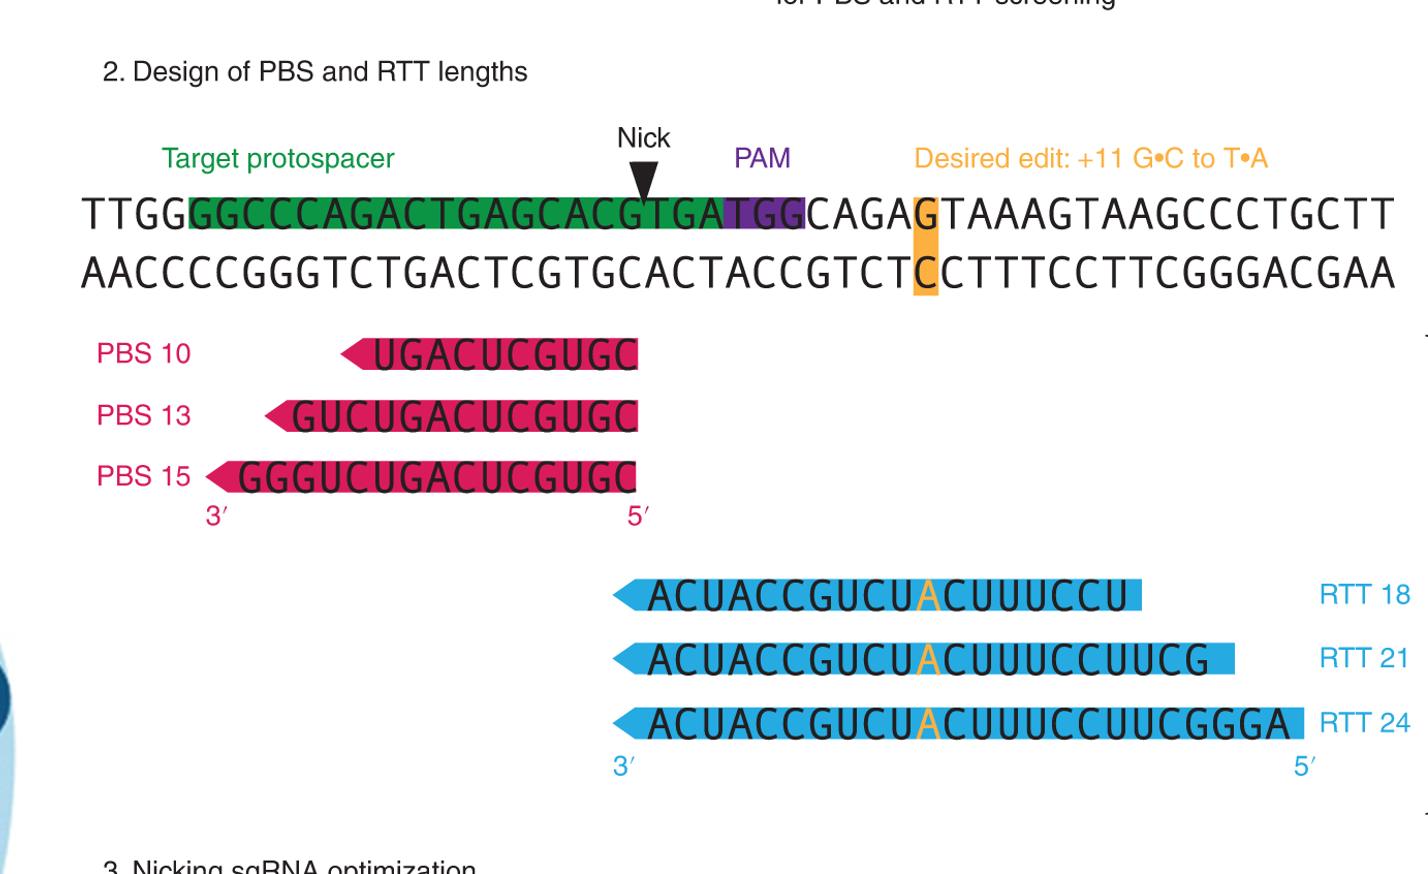

In [657]:
import numpy as np
import random

@dataclasses.dataclass
class MutatedCodon:
    original_codon: Codon
    mutated_codon: Codon
    hamming_distance: int

# Note 9/21/2022 - only just supporting one codon sample since for our case it is just the stop codon, could change to list of tuples to support more in the future
@typechecked
def mutate_sequence_primeeditingscreen(coding_tiling_sequence: CodingTilingSequence, dna_codon_frequency_map: Mapping[str, List[Tuple[str, float]]], dna_codon_map: Mapping[str, str], ignore_codon_letters: List[str] = ["_"], add_synonymous_mutations:bool=False, highest_frequent_codon:bool=False):
    '''
        Helper function for getting the final mutant sequence
    '''
    def get_mutant_sequence(codon_set_arg: List[Codon], codon_index = None) -> Tuple[str, str]:
        new_sequence = "".join([str(codon.codon_sequence) for codon in codon_set_arg])
        new_sequence_spaced = new_sequence
        if codon_index != None:
            new_sequence_left = "".join([str(codon.codon_sequence) for codon in codon_set_arg[:codon_index]])
            new_sequence_codon = str(codon_set_arg[codon_index].codon_sequence)
            new_sequence_right = "".join([str(codon.codon_sequence) for codon in codon_set_arg[codon_index+1:]])
            new_sequence_spaced = new_sequence_left +" "+new_sequence_codon + " " + new_sequence_right
        return new_sequence, new_sequence_spaced
            
    
    # This list will contain the set of all mutated sequences
    mutated_sequences: List[MutatedCodon] = []
    
    '''
        Add the WT oligo
    '''
    # Append the WT seqeunce
    wt_sequences_tuple = get_mutant_sequence(coding_tiling_sequence.tiled_codon_set)
    mutated_sequences.append((None, (None, None), (None, None), coding_tiling_sequence.tiled_codon_set, wt_sequences_tuple[0], wt_sequences_tuple[1], None))
    
    
    '''
        Iterate through each codon (which will be mutated to every other codon)
    '''
    tiled_codon_mutations:List[List[List[Mappable]]] = []
    tiled_codon: Codon
    codon_index: int
    for codon_index, tiled_codon in enumerate(coding_tiling_sequence.tiled_codon_set):
        print("Getting pegRNAs for codon {}/{}: {}".format(codon_index, len(coding_tiling_sequence.tiled_codon_set), tiled_codon))
        mutated_codon_list = list(dna_codon_frequency_map.keys()) 
        codon_letter = dna_codon_map[tiled_codon.codon_sequence]
        
        '''
            If not adding any synonymous mutations, then remove the same codon from the list to mutate to
        '''
        if not add_synonymous_mutations:
            mutated_codon_list.remove(codon_letter)
       
        '''
            Remove codons to ignore
        '''
        for ignored_codon_letter in ignore_codon_letters:
            mutated_codon_list.remove(ignored_codon_letter)
        
        '''
            Iterate through the list of codon variants "mutated_codon_list" to mutate to 
        '''
        mutated_codon_letter_mutations:List = []
        mutated_codon_letter: str
        for mutated_codon_letter in mutated_codon_list:
            print("\tAA Mutation {}>{}".format(codon_letter, mutated_codon_letter))
            '''
                Get all possible trinucleotide codon based on the residue letter
            '''
            possible_DNA_codons: List[Tuple[str, float]] = dna_codon_frequency_map[mutated_codon_letter]
            possible_DNA_codons = [possible_codon for possible_codon in possible_DNA_codons if possible_codon[0] != str(tiled_codon.codon_sequence)] # If synonymous codon letter, remove the exact same codon trinucleotide
            
            # If there are no codons to mutate to (for instance, the synonymous codon only has one codon trinucleotide which was removed)
            if len(possible_DNA_codons) == 0: 
                continue
              
            '''
                Determine the final list of trinucleotide codons to mutate for corresponding residue:
                i.e. only the highest frequent trinucleotide in the human genome or all the trinucleotides: 
            '''
            dna_codon_frequencies: List[float] = [possible_codon[1] for possible_codon in possible_DNA_codons]
            if highest_frequent_codon == True:
                mutated_DNA_codons:List[Seq] = [Seq(possible_DNA_codons[np.argmax(dna_codon_frequencies)][0])] # Get most frequent codon
            else:
                mutated_DNA_codons:List[Seq] = [Seq(codon[0]) for codon in possible_DNA_codons] # Get most frequent codon
        
            '''
                Create the MutatedCodon object list for each trinclueotide codon to mutate to. 
            '''
            mutated_codons:List[MutatedCodon] = []
            mutated_DNA_codon: Seq
            for mutated_DNA_codon in mutated_DNA_codons:
                mutated_codon: Codon = dataclasses.replace(tiled_codon)
                mutated_codon.codon_sequence = mutated_DNA_codon
                mutated_codon_obj = MutatedCodon(original_codon=tiled_codon, mutated_codon=mutated_codon, hamming_distance=calculate_hamming(mutated_codon.codon_sequence, tiled_codon.codon_sequence))
                mutated_codons.append(mutated_codon_obj)

                    
            '''
                We have generated all the mutated codons for saturation mutagenesis, now iterate through each one and create the 
                different PrimeDesign sequences that vary based on PAM-disrupting mutation and synonymous mutation
                
                This is where the main pegRNA design is done.
            '''
            mutated_codon_sequence_mutations: List[Mappable] = []
            mutated_codon_i: int
            mutated_codon: MutatedCodon
            for mutated_codon_i, mutated_codon in enumerate(mutated_codons):
                print("\t\tCodon Mutation {}>{}".format(str(mutated_codon.original_codon.codon_sequence), str(mutated_codon.mutated_codon.codon_sequence)))
                '''
                    Get the expected mutated sequence based on the mutated codon, along with its reverse complement
                    
                    This sequence is needed to geenerate the pegRNA, specifically determining where the nick site can be and if the mutant is already PAM-disrupting
                ''' 
                mutated_sequence = list(str(coding_tiling_sequence.complete_sequence))
                mutated_sequence[coding_tiling_sequence.tiling_coordinates[0]+mutated_codon.original_codon.genome_index_start:coding_tiling_sequence.tiling_coordinates[0]+mutated_codon.original_codon.genome_index_stop] = mutated_codon.mutated_codon.codon_sequence
                mutated_sequence = "".join(mutated_sequence)
                mutated_sequence_revcomp = str(Seq(mutated_sequence).reverse_complement())
                assert len(mutated_sequence) == len(coding_tiling_sequence.complete_sequence), "Ensure mutated and original sequence is same length, {}, {}".format(len(mutated_sequence), len(coding_tiling_sequence.complete_sequence))
                # Tunable parameter, max RTT considered. Set to 25 since literature suggests over 25 sacrifices efficiency
                max_rtt_length_considered=21
                
                '''
                     Get the position of the mutated truncleotide that is different (which determines the exact position the RT can start)
                '''
                first_position_difference = get_first_position_difference(mutated_codon.original_codon.codon_sequence, mutated_codon.mutated_codon.codon_sequence) # This is for the forward orientaion
                last_position_difference = get_last_position_difference(mutated_codon.original_codon.codon_sequence, mutated_codon.mutated_codon.codon_sequence) # This is for the reverse complement orientation
                assert first_position_difference >= 0 and first_position_difference < 3
                assert last_position_difference >= 0 and last_position_difference < 3
                
                complete_sequence = coding_tiling_sequence.complete_sequence
                assert str(mutated_codon.original_codon.codon_sequence) == complete_sequence[coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start:coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_stop], "Ensure that codon is as expected based on coordinates, codon={}; coordinate_codon={}; coordinate_start={}, coordinate_end={}, codon={}".format(str(mutated_codon.original_codon.codon_sequence), complete_sequence[coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start:coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_stop], coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start, coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_stop, mutated_codon.original_codon)
                
                '''
                    Retrieve the possible coordinates of the RTT forward pegRNA
                '''
                RT_minimum_first_forward = coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start + first_position_difference
                RT_minimum_last_forward = coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start + last_position_difference
                most_upstream_nick_site_forward = RT_minimum_last_forward-max_rtt_length_considered
                most_downstream_nick_site_forward = RT_minimum_first_forward
                
                '''
                    Based on the possible RTT coordinates, get the possible PAM positions for the forward pegRNA
                '''
                possible_pam_sequence_forward_START = most_upstream_nick_site_forward+3 # This would place the last SNV to edit at the last position of the RTT, the +3 is pass the 3nt seed to the start PAM
                possible_pam_sequence_forward_END = most_downstream_nick_site_forward+6 # This would place the first SNV to edit at the first position of the RTT, the +6 is to pass the 3nt seed and 3nt PAM to end at the end of the PAM
                possible_pam_sequence_forward = str(complete_sequence[possible_pam_sequence_forward_START:possible_pam_sequence_forward_END])
                possible_pam_sequence_forward_coordinates = possible_pam_sequence_forward_START + findall("GG", possible_pam_sequence_forward[1:]) # 
                
                '''
                    Retrieve the possible coordinates of the RTT reverse pegRNA
                '''
                complete_sequence_revcomp = Seq(complete_sequence).reverse_complement()
                RT_minimum_first_reverse = len(complete_sequence_revcomp) - RT_minimum_first_forward -1 #TODO: Check for off by one error
                RT_minimum_last_reverse = len(complete_sequence_revcomp) - RT_minimum_last_forward -1 #TODO: Check for off by one error
                most_upstream_nick_site_reverse = RT_minimum_last_reverse-max_rtt_length_considered
                most_downstream_nick_site_reverse = RT_minimum_first_reverse
                
                '''
                    Based on the possible RTT coordinates, get the possible PAM positions for the reverse pegRNA
                '''
                possible_pam_sequence_reverse_START = most_upstream_nick_site_reverse+3 # This would place the last SNV to edit at the last position of the RTT
                possible_pam_sequence_reverse_END = most_downstream_nick_site_reverse+6 # This would place the first SNV to edit at the first position of the RTT
                possible_pam_sequence_reverse = str(complete_sequence_revcomp[possible_pam_sequence_reverse_START:possible_pam_sequence_reverse_END])
                possible_pam_sequence_reverse_coordinates = possible_pam_sequence_reverse_START + findall("GG", possible_pam_sequence_reverse[1:]) # 
                
                '''
                    STEP1 Check if the edit already mutates the PAM/seed by iterating through all possible PAMs.
                ''' 
                codon_start_position_forward = coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_start
                codon_stop_position_forward = coding_tiling_sequence.tiling_coordinates[0] + mutated_codon.original_codon.genome_index_stop
                
                # TODO: There may be an off by one error here
                codon_stop_position_reverse = len(complete_sequence) - codon_start_position_forward # TODO: Check for off by one
                codon_start_position_reverse = len(complete_sequence) - codon_stop_position_forward # TODO: Check for off by one
                
                
                '''
                    STEP1A - iterate through forward PAMs to determine if disrupted by the edit
                '''
                is_edit_fwd_pam_disrupting = False
                is_edit_fwd_seed_disrupting = False
                pam_disrupted_forward_coordinates: List[int] = []
                for possible_pam_sequence_forward_coordinate in possible_pam_sequence_forward_coordinates: 
                    if codon_stop_position_forward >= possible_pam_sequence_forward_coordinate-3 and codon_start_position_forward <= possible_pam_sequence_forward_coordinate+3: # If PAM coord is within the codon coord
                        mutated_pam_sequence = mutated_sequence[possible_pam_sequence_forward_coordinate-3:possible_pam_sequence_forward_coordinate+3]
                        is_disrupted = False
                        is_current_edit_pam_disrupting = False
                        if mutated_pam_sequence[-2:] != "GG":
                            is_edit_fwd_pam_disrupting = True
                            is_current_edit_pam_disrupting = True
                            is_disrupted = True
                        if str(mutated_sequence[possible_pam_sequence_forward_coordinate-3:possible_pam_sequence_forward_coordinate]) != str(complete_sequence[possible_pam_sequence_forward_coordinate-3:possible_pam_sequence_forward_coordinate]):
                            is_edit_fwd_seed_disrupting = True
                            is_disrupted = True
                            
                        if is_disrupted:
                            pam_disrupted_forward_coordinates.append((possible_pam_sequence_forward_coordinate, is_current_edit_pam_disrupting)) # False for seed-disruption
                
                '''
                    STEP1B - iterate through reverse PAMs to determine if disrupted by the edit
                '''
                is_edit_rev_pam_disrupting = False
                is_edit_rev_seed_disrupting = False
                pam_disrupted_reverse_coordinates: List[int] = []
                for possible_pam_sequence_reverse_coordinate in possible_pam_sequence_reverse_coordinates: 
                    if codon_stop_position_reverse >= possible_pam_sequence_reverse_coordinate-3 and codon_start_position_reverse <= possible_pam_sequence_reverse_coordinate+3: # If PAM coord is within the codon coord
                        mutated_pam_sequence = mutated_sequence_revcomp[possible_pam_sequence_reverse_coordinate-3:possible_pam_sequence_reverse_coordinate+3]
                        is_disrupted = False
                        is_current_edit_pam_disrupting = False
                        if mutated_pam_sequence[-2:] != "GG":
                            is_edit_rev_pam_disrupting = True
                            is_current_edit_pam_disrupting = True
                            is_disrupted = True
                        if str(mutated_sequence_revcomp[possible_pam_sequence_reverse_coordinate-3:possible_pam_sequence_reverse_coordinate]) != str(complete_sequence_revcomp[possible_pam_sequence_reverse_coordinate-3:possible_pam_sequence_reverse_coordinate]):
                            is_edit_rev_seed_disrupting = True
                            is_disrupted = True
                            
                        if is_disrupted:
                            pam_disrupted_reverse_coordinates.append((possible_pam_sequence_reverse_coordinate, is_current_edit_pam_disrupting)) # False for seed-disruption
                
                forward_protospacers = []
                for pam_sequence_forward_coordinate, pam_disrupting in pam_disrupted_forward_coordinates:
                    print("\t\t\tPAM coordinate: {}".format(pam_sequence_forward_coordinate))
                    print("\t\t\tPAM: {}>{}".format(complete_sequence[pam_sequence_forward_coordinate-3:pam_sequence_forward_coordinate+3], mutated_sequence[pam_sequence_forward_coordinate-3:pam_sequence_forward_coordinate+3]))
                    forward_protospacers.append((complete_sequence[pam_sequence_forward_coordinate-20:pam_sequence_forward_coordinate+3], pam_sequence_forward_coordinate - codon_start_position_forward, pam_disrupting))
                reverse_protospacers = []
                for pam_sequence_reverse_coordinate, pam_disrupting in pam_disrupted_reverse_coordinates:
                    print("\t\t\tPAM coordinate: {}".format(pam_sequence_reverse_coordinate))
                    print("\t\t\tPAM: {}>{}".format(complete_sequence_revcomp[pam_sequence_reverse_coordinate-3:pam_sequence_reverse_coordinate+3], mutated_sequence_revcomp[pam_sequence_reverse_coordinate-3:pam_sequence_reverse_coordinate+3]))
                    reverse_protospacers.append((complete_sequence_revcomp[pam_sequence_reverse_coordinate-20:pam_sequence_reverse_coordinate+3], pam_sequence_reverse_coordinate-codon_start_position_reverse, pam_disrupting))
                
                '''
                    Add the mutations to the list
                '''
                mutated_codon_sequence_mutations.append({"tiled_mutated_codon": mutated_codon, "coding_mutated_codon": None, "is_edit_pam_disrupting": is_edit_fwd_pam_disrupting, "is_edit_seed_disrupting": is_edit_fwd_seed_disrupting, "orientation": "+", "protospacers": forward_protospacers})
                mutated_codon_sequence_mutations.append({"tiled_mutated_codon": mutated_codon, "coding_mutated_codon": None, "is_edit_pam_disrupting": is_edit_rev_pam_disrupting, "is_edit_seed_disrupting": is_edit_rev_seed_disrupting, "orientation": "-", "protospacers": reverse_protospacers})
                
                '''
                    If the desired edit is not PAM disrupting (which is typically the case that the edit is not PAM-disrupting), generate PAM-disrupting synonymous mutations
                '''
                generate_synonymous_pam_disruptions = True # To always generate synonymous mutations
                if (len(pam_disrupted_forward_coordinates) == 0) and (len(pam_disrupted_reverse_coordinates) == 0) or generate_synonymous_pam_disruptions:
                    print("\t\tMutated codon is not PAM-disrupting, now generating PAM-disrupting synonymous mutations")
                    # Contains list of PAM-disrupting synonymous mutations for fwd pegRNA: SynCodon, OrigCodon, pam_position
                    syn_codons_fwd_valid: List[Tuple[str, Codon, int]] = []
                    
                    '''
                        Iterate through all the PAM start coordinates that is within the PAM possible zone.
                    '''
                    for pam_sequence_forward_coordinate in possible_pam_sequence_forward_coordinates:
                        print("\t\t\tPAM forward coordinate: {}".format(pam_sequence_forward_coordinate))
                        '''
                            Ensure that the PAM is within the coding region, so that a synonymous mutation is able to be designed
                        '''
                        if (pam_sequence_forward_coordinate+3) > coding_tiling_sequence.coding_coordinates[0] and pam_sequence_forward_coordinate < coding_tiling_sequence.coding_coordinates[1]: 
                            '''
                                Get the codons that overlap the PAM, these are candidates for synonymous mutation for PAM disruption. These codons do not have to be within the tiling region.
                            '''
                            get_codon_start_absolute_fwd = lambda codon: coding_tiling_sequence.coding_coordinates[0] + codon.genome_index_start 
                            get_codon_stop_absolute_fwd = lambda codon: coding_tiling_sequence.coding_coordinates[0] + codon.genome_index_stop 
                            
                            # Get all codons codons that are within a PAM-disrupting sequencing
                            forward_codon_within_pegRNA_pam = [codon for codon in coding_tiling_sequence.coding_codon_set if (pam_sequence_forward_coordinate+1 >= get_codon_start_absolute_fwd(codon)) and (pam_sequence_forward_coordinate+1 < get_codon_stop_absolute_fwd(codon))] # NOTE 20221211 - I added a +1 since I want to check if the GG is within the codon, not the NGG
                            
                            '''
                                Iterate through each PAM-overlappng codons and get the possible synonymous codons - we will soon need to check that these synonymous mutations are actually PAM-disrupting
                            '''
                            for codon in forward_codon_within_pegRNA_pam:
                                print("\t\t\t\tOverlapping Codon: {},{}; PAM: {},{}".format(codon.codon_sequence, get_codon_start_absolute_fwd(codon), complete_sequence[pam_sequence_forward_coordinate-3:pam_sequence_forward_coordinate+5], pam_sequence_forward_coordinate))
                                codon_sequence = str(codon.codon_sequence)
                                
                                # This gets the synonymous codons
                                syn_codons: List[str] = [syn_codon for syn_codon,_ in dna_codon_frequency_map[dna_codon_map[codon_sequence]] if syn_codon != codon_sequence]
                                
                                '''
                                    Iterate through each PAM-overlapping codon for validation based on these criteria
                                    - Is it within the possible RTT
                                    - Does it actually disrupt the NGG PAM
                                '''
                                for syn_codon in syn_codons: 
                                    
                                    '''
                                        Get some positional information about the synonymous mutation
                                        - What is the first position of a difference between the original and mutated codon.
                                        - What is the last position of a difference between the original and mutated codon.
                                        - What are all positional differences between the original and mutated codon.
                                    '''
                                    syn_codon_first_position_difference = get_first_position_difference(codon_sequence, syn_codon) 
                                    syn_codon_last_position_difference = get_last_position_difference(codon_sequence, syn_codon)
                                    syn_codon_all_position_differences = get_all_position_differences(codon_sequence, syn_codon)
                                    
                                    syn_codon_first_position_difference_absolute = get_codon_start_absolute_fwd(codon) + syn_codon_first_position_difference
                                    syn_codon_last_position_difference_absolute =  get_codon_start_absolute_fwd(codon) + syn_codon_last_position_difference
                                    syn_codon_all_position_differences_absolute = [get_codon_start_absolute_fwd(codon) + position for position in syn_codon_all_position_differences]
                                    print("\t\t\t\tAbsolute: {}, PAM: {}".format(syn_codon_all_position_differences_absolute, pam_sequence_forward_coordinate))
                                    '''
                                        Ensure that the synonymous mutation is PAM disrupting
                                    '''
                                    # Just confirm that the expected region is a PAM
                                    assert coding_tiling_sequence.complete_sequence[pam_sequence_forward_coordinate+1:pam_sequence_forward_coordinate+3] == "GG" 
                                    
                                    mutates_pam = False
                                    for syn_codon_position_difference in syn_codon_all_position_differences_absolute:
                                        if (syn_codon_position_difference >= pam_sequence_forward_coordinate+1) and (syn_codon_position_difference <= pam_sequence_forward_coordinate+3):
                                            mutates_pam = True # TODO: Definitely need to validate the logic here with some print statements to ensure that the synonymous mutations are actually disrupting the PAM
                                    
                                    if mutates_pam != True:
                                        print("\t\t\t\t\tSynonymous mutation does not mutate PAM: {}>{}".format(codon.codon_sequence, syn_codon))
                                        continue # If the synonymous mutation does not mutate PAM, then skip and continue to checking the next synonymous mutation
                                    
                                    '''
                                        Ensure that the synonymous mutation is within the RTT
                                    '''
                                    within_RTT = (syn_codon_first_position_difference_absolute >= most_upstream_nick_site_forward) and (syn_codon_last_position_difference_absolute < most_downstream_nick_site_forward)  # TODO: Check for off-by-one error
                                    if within_RTT != True:
                                        print("\t\t\t\t\tSynonymous mutation not within RTT: {}>{}".format(codon.codon_sequence, syn_codon))
                                        continue # If the synonymous mutation is not within the RTT, then skip and continue to checking the next synonymous mutation
                                    
                                     # Get the target protospacer
                                    protospacer = [(complete_sequence[pam_sequence_forward_coordinate-20:pam_sequence_forward_coordinate+3], pam_sequence_forward_coordinate - codon_start_position_forward, True)]
                                
                                    print("\t\t\t\tPAM-disrupting synonymous mutation: {}>{}".format(codon.codon_sequence, syn_codon))
                                    #syn_codons_fwd_valid.append((syn_codon, codon, pam_sequence_forward_coordinate))
                                    
                                    mutated_syn_codon: Codon = dataclasses.replace(codon)
                                    mutated_syn_codon.codon_sequence = syn_codon
                                    mutated_syn_codon_obj = MutatedCodon(original_codon=codon, mutated_codon=mutated_syn_codon, hamming_distance=calculate_hamming(mutated_syn_codon.codon_sequence, codon.codon_sequence))
                                    mutated_codon_sequence_mutations.append({"tiled_mutated_codon": mutated_codon, "coding_mutated_codon": mutated_syn_codon_obj, "is_edit_pam_disrupting": is_edit_fwd_pam_disrupting, "is_edit_seed_disrupting": is_edit_fwd_seed_disrupting, "orientation": "+", "protospacers": protospacer})
                                
                    # Contains list of PAM-disrupting synonymous mutations for rev pegRNA: SynCodon, OrigCodon, pam_position
                    syn_codons_rev_valid: List[Tuple[str, Codon, int]] = []

                    '''
                        Iterate through all the PAM start coordinates that is within the PAM possible zone.
                    '''
                    for pam_sequence_reverse_coordinate in possible_pam_sequence_reverse_coordinates:
                        print("\t\t\tPAM reverse coordinate: {}".format(pam_sequence_reverse_coordinate))
                        '''
                            Ensure that the PAM is within the coding region, so that a synonymous mutation is able to be designed
                        '''
                        if (pam_sequence_reverse_coordinate+3) > (len(coding_tiling_sequence.complete_sequence) - coding_tiling_sequence.coding_coordinates[1]) and pam_sequence_reverse_coordinate < (len(coding_tiling_sequence.complete_sequence)-coding_tiling_sequence.coding_coordinates[0]):
                            '''
                                Get the codons that overlap the PAM, these are candidates for synonymous mutation for PAM disruption. These codons do not have to be within the tiling region.
                            '''
                            get_codon_start_absolute_rev = lambda codon: len(coding_tiling_sequence.complete_sequence) - (coding_tiling_sequence.coding_coordinates[0] + codon.genome_index_start)
                            get_codon_stop_absolute_rev = lambda codon: len(coding_tiling_sequence.complete_sequence) - (coding_tiling_sequence.coding_coordinates[0] + codon.genome_index_stop)


                            # Get all codons codons that are within a PAM-disrupting sequencing
                            reverse_codon_within_pegRNA_pam = [codon for codon in coding_tiling_sequence.coding_codon_set if (pam_sequence_reverse_coordinate+1 >= get_codon_stop_absolute_rev(codon)) and (pam_sequence_reverse_coordinate+1 < get_codon_start_absolute_rev(codon))] # NOTE 20221211 - I added a +1 since I want to check if the GG is within the codon, not the NGG

                            '''
                                Iterate through each PAM-overlappng codons and get the possible synonymous codons - we will soon need to check that these synonymous mutations are actually PAM-disrupting
                            '''
                            for codon in reverse_codon_within_pegRNA_pam:
                                print("\t\t\t\tOverlapping Codon: {},{}; PAM: {},{}".format(codon.codon_sequence.reverse_complement(), get_codon_stop_absolute_rev(codon), complete_sequence_revcomp[pam_sequence_reverse_coordinate-3:pam_sequence_reverse_coordinate+3], pam_sequence_reverse_coordinate))
                                codon_sequence = str(codon.codon_sequence)
                                codon_sequence_revcomp = str(codon.codon_sequence.reverse_complement())
                                # This gets the synonymous codons
                                syn_codons: List[str] = [syn_codon for syn_codon,_ in dna_codon_frequency_map[dna_codon_map[codon_sequence]] if syn_codon != codon_sequence]

                                '''
                                    Iterate through each PAM-overlapping codon for validation based on these criteria
                                    - Is it within the possible RTT
                                    - Does it actually disrupt the NGG PAM
                                '''
                                for syn_codon in syn_codons: 

                                    '''
                                        Get some positional information about the synonymous mutation
                                        - What is the first position of a difference between the original and mutated codon.
                                        - What is the last position of a difference between the original and mutated codon.
                                        - What are all positional differences between the original and mutated codon.
                                    '''
                                    syn_codon_revcomp = str(Seq(syn_codon).reverse_complement())
                                    syn_codon_first_position_difference = get_first_position_difference(codon_sequence_revcomp, syn_codon_revcomp) 
                                    syn_codon_last_position_difference = get_last_position_difference(codon_sequence_revcomp, syn_codon_revcomp)
                                    syn_codon_all_position_differences = get_all_position_differences(codon_sequence_revcomp, syn_codon_revcomp)

                                    syn_codon_first_position_difference_absolute = get_codon_stop_absolute_rev(codon) + syn_codon_first_position_difference
                                    syn_codon_last_position_difference_absolute =  get_codon_stop_absolute_rev(codon) + syn_codon_last_position_difference
                                    syn_codon_all_position_differences_absolute = [get_codon_stop_absolute_rev(codon) + position for position in syn_codon_all_position_differences]
                                    print("\t\t\t\tAbsolute: {}, PAM: {}".format(syn_codon_all_position_differences_absolute, pam_sequence_reverse_coordinate))
                                    '''
                                        Ensure that the synonymous mutation is PAM disrupting
                                    '''
                                    # Just confirm that the expected region is a PAM
                                    assert coding_tiling_sequence.complete_sequence.reverse_complement()[pam_sequence_reverse_coordinate+1:pam_sequence_reverse_coordinate+3] == "GG" 

                                    mutates_pam = False
                                    for syn_codon_position_difference in syn_codon_all_position_differences_absolute:
                                        if (syn_codon_position_difference >= pam_sequence_reverse_coordinate+1) and (syn_codon_position_difference <= pam_sequence_reverse_coordinate+3):
                                            mutates_pam = True # TODO: Definitely need to validate the logic here with some print statements to ensure that the synonymous mutations are actually disrupting the PAM

                                    if mutates_pam != True:
                                        print("\t\t\t\t\tSynonymous mutation does not mutate PAM: {}>{}".format(codon_sequence_revcomp, syn_codon_revcomp))
                                        continue # If the synonymous mutation does not mutate PAM, then skip and continue to checking the next synonymous mutation

                                    '''
                                        Ensure that the synonymous mutation is within the RTT
                                    '''
                                    within_RTT = (syn_codon_first_position_difference_absolute >= most_upstream_nick_site_reverse) and (syn_codon_last_position_difference_absolute < most_downstream_nick_site_reverse)  # TODO: Check for off-by-one error
                                    if within_RTT != True:
                                        print("\t\t\t\t\tSynonymous mutation not within RTT: {}>{}".format(codon_sequence_revcomp, syn_codon_revcomp))
                                        continue # If the synonymous mutation is not within the RTT, then skip and continue to checking the next synonymous mutation

                                    # Get the target protospacer
                                    protospacer = [(complete_sequence_revcomp[pam_sequence_reverse_coordinate-20:pam_sequence_reverse_coordinate+3], pam_sequence_reverse_coordinate - codon_start_position_reverse, True)]
                                    
                                    print("\t\t\t\tPAM-disrupting synonymous mutation: {}>{}".format(codon_sequence_revcomp, syn_codon_revcomp))
                                    #syn_codons_rev_valid.append((syn_codon, codon, pam_sequence_reverse_coordinate))
                                    
                                    mutated_syn_codon: Codon = dataclasses.replace(codon)
                                    mutated_syn_codon.codon_sequence = syn_codon
                                    mutated_syn_codon_obj = MutatedCodon(original_codon=codon, mutated_codon=mutated_syn_codon, hamming_distance=calculate_hamming(mutated_syn_codon.codon_sequence, codon.codon_sequence))
                                    mutated_codon_sequence_mutations.append({"tiled_mutated_codon": mutated_codon, "coding_mutated_codon": mutated_syn_codon_obj, "is_edit_pam_disrupting": is_edit_rev_pam_disrupting, "is_edit_seed_disrupting": is_edit_rev_seed_disrupting, "orientation": "-", "protospacers": protospacer})
            mutated_codon_letter_mutations.append((codon_letter, mutated_codon_letter, mutated_codon_sequence_mutations))
        tiled_codon_mutations.append((codon_index, tiled_codon, mutated_codon_letter_mutations))    
    return tiled_codon_mutations 

In [ ]:
# Run function to get pegRNA mutations
tiled_codon_mutations = mutate_sequence_primeeditingscreen(coding_tiling_sequence, dna_codon_frequency_map=dna_codon_frequency_map, dna_codon_map=dna_codon_map, add_synonymous_mutations=True, highest_frequent_codon=False)

In [659]:
# Function to trim edits, i.e. (AGGC/ATTC) will be trimmed to (GG/TT) since first and last positions are the same.
def trim_edits(original_sequence: str, new_sequence: str):
    # Get original and new sequence, uppercase
    original_sequence = original_sequence.upper()
    new_sequence = new_sequence.upper()
    
    # Ensure sequences are the same length and are not identical
    assert len(original_sequence) == len(new_sequence), "Sequences are not same length"
    assert original_sequence != new_sequence, "Sequences are equivalent"
    
    # Find first position that is not identical
    left_index_same = 0
    for i in range(len(original_sequence)):
        if original_sequence[i] == new_sequence[i]:
            continue
        else:
            left_index_same = i
            break
      
    # Find last position that is not identical
    right_index_same = len(original_sequence)
    for i in range(len(original_sequence)):
        if original_sequence[len(original_sequence)-i-1] == new_sequence[len(original_sequence)-i-1]:
            continue
        else:
            right_index_same = len(original_sequence)-i
            break
            
    # Index to get new sequences
    left_sequence_same = original_sequence[:left_index_same]
    right_sequence_same = original_sequence[right_index_same:]
    original_sequence_different = original_sequence[left_index_same:right_index_same]
    new_sequence_different = new_sequence[left_index_same:right_index_same]
    
    # Return
    return((left_index_same, right_index_same), (left_sequence_same, right_sequence_same), (original_sequence_different, new_sequence_different))

In [660]:
'''
    From the mutated codons specified above, generate the inputs to the PRIDICT tool
'''

pridict_sequences:List[pd.Series] = [] 
tiled_codon_mutation: Tuple[int, Codon, List]
# Iterate through each codon in the tiled region
for tiled_codon_mutation in tiled_codon_mutations:
    
    codon_index = tiled_codon_mutation[0]
    original_codon = tiled_codon_mutation[1]
    mutated_codon_letter_mutations = tiled_codon_mutation[2]
    mutated_codon_letter_mutation: Tuple[str, List]
        
    # Iterate through each new codon letter to mutate to for the particular original codon
    for mutated_codon_letter_mutation in mutated_codon_letter_mutations:
        codon_letter: str = mutated_codon_letter_mutation[0]
        mutated_codon_letter:str = mutated_codon_letter_mutation[1]
        mutated_codon_sequence_mutations:List = mutated_codon_letter_mutation[2]
            
        # Iterate through each new codon sequence for the new codon letter to mutate to
        for mutated_codon_sequence_mutation in mutated_codon_sequence_mutations:
            # Retrieve the necessary information for the PRIDICT input
            tiled_mutated_codon: MutatedCodon = mutated_codon_sequence_mutation["tiled_mutated_codon"]
            coding_mutated_codon: MutatedCodon = mutated_codon_sequence_mutation["coding_mutated_codon"]
            is_edit_pam_disrupting: bool = mutated_codon_sequence_mutation["is_edit_pam_disrupting"]
            is_edit_seed_disrupting: bool = mutated_codon_sequence_mutation["is_edit_seed_disrupting"]
            orientation: str = mutated_codon_sequence_mutation["orientation"]
            protospacer: List[Tuple[str,int, bool]] = mutated_codon_sequence_mutation["protospacers"]
            protospacer = [(str(proto[0]), proto[1], proto[2]) for proto in protospacer]
            
            for proto in protospacer:
                assert proto[0][-2:] == "GG", "{} does not have an NGG PAM".format(proto[0])
                
            '''
                For everything below, prepare PRIDICT inputs and save
            '''
            tiled_mutated_codon_start_abs = coding_tiling_sequence.tiling_coordinates[0] + tiled_mutated_codon.mutated_codon.genome_index_start
            tiled_mutated_codon_stop_abs = coding_tiling_sequence.tiling_coordinates[0] + tiled_mutated_codon.mutated_codon.genome_index_stop
            
            first_codon = tiled_mutated_codon
            first_codon_start = tiled_mutated_codon_start_abs
            first_codon_stop = tiled_mutated_codon_stop_abs
            
            last_codon = tiled_mutated_codon
            last_codon_start = tiled_mutated_codon_start_abs
            last_codon_stop = tiled_mutated_codon_stop_abs
            hamming_distance = tiled_mutated_codon.hamming_distance
            if coding_mutated_codon != None:
                coding_mutated_codon_start_abs = coding_tiling_sequence.coding_coordinates[0] + coding_mutated_codon.mutated_codon.genome_index_start
                coding_mutated_codon_stop_abs = coding_tiling_sequence.coding_coordinates[0] + coding_mutated_codon.mutated_codon.genome_index_stop
                hamming_distance += coding_mutated_codon.hamming_distance
                if coding_mutated_codon_start_abs < tiled_mutated_codon_start_abs:
                    first_codon = coding_mutated_codon
                    first_codon_start = coding_mutated_codon_start_abs
                    first_codon_stop = coding_mutated_codon_stop_abs
                else:
                    last_codon = coding_mutated_codon
                    last_codon_start = coding_mutated_codon_start_abs
                    last_codon_stop = coding_mutated_codon_stop_abs
            
            left_sequence_length = 100
            right_sequence_length = 100
            
            left_sequence = coding_tiling_sequence.complete_sequence[first_codon_start-left_sequence_length:first_codon_start]
            first_codon_original = str(first_codon.original_codon.codon_sequence)
            first_codon_mutated = str(first_codon.mutated_codon.codon_sequence)
            
            last_codon_original = str(last_codon.original_codon.codon_sequence)
            last_codon_mutated = str(last_codon.mutated_codon.codon_sequence)
            
            sequence_between = coding_tiling_sequence.complete_sequence[first_codon_stop:last_codon_start]
            
            right_sequence = coding_tiling_sequence.complete_sequence[last_codon_stop:last_codon_stop+right_sequence_length]
            
            mutation_sequence = None
            if first_codon != last_codon:
                original_sequence = first_codon_original + sequence_between + last_codon_original 
                new_sequence = first_codon_mutated + sequence_between + last_codon_mutated
                
                (left_index_same, right_index_same), (left_sequence_same, right_sequence_same), (original_sequence_different, new_sequence_different) = trim_edits(original_sequence=original_sequence, new_sequence=new_sequence)
                mutation_sequence = original_sequence_different + "/" + new_sequence_different
                pridict_sequence = left_sequence + left_sequence_same + "({})".format(mutation_sequence) + right_sequence_same + right_sequence
            else:
                (left_index_same, right_index_same), (left_sequence_same, right_sequence_same), (original_sequence_different, new_sequence_different) = trim_edits(original_sequence=first_codon_original, new_sequence=first_codon_mutated)
                mutation_sequence = original_sequence_different + "/" + new_sequence_different
                pridict_sequence = left_sequence + left_sequence_same + "({})".format(mutation_sequence) + right_sequence_same + right_sequence
                
            
            
            pridict_sequences.append(pd.Series([codon_index, original_codon.genome_index_start, original_codon.genome_index_stop, codon_letter, mutated_codon_letter, str(original_codon.codon_sequence),
                       str(tiled_mutated_codon.mutated_codon.codon_sequence),str(coding_mutated_codon.original_codon.codon_sequence) if coding_mutated_codon != None else None, str(coding_mutated_codon.mutated_codon.codon_sequence) if coding_mutated_codon != None else None, is_edit_pam_disrupting, is_edit_seed_disrupting, orientation, hamming_distance, protospacer, str(mutation_sequence), str(pridict_sequence)],
                                              index=["codon_index", "codon_relative_start", "codon_relative_stop", "original_codon_letter", "mutated_codon_letter", "original_codon_sequence", "mutated_codon_sequence", "original_synonymous_mutation", "mutated_synonymous_mutation", "is_edit_pam_disrupting", "is_edit_seed_disrupting", "pegRNA_orientation", "hamming", "protospacers_with_pam", "sequence_swap", "pridict_sequence"]))
                
            
    

In [661]:
# Save results to dataframe
pridict_sequences_df = pd.DataFrame(pridict_sequences)

In [662]:
# Drop any rows that have duplicate "pridict_sequence" values as the PRIDICT output would be the same for duplicate pridict_sequence
pridict_sequences_df_final = pridict_sequences_df.drop_duplicates("pridict_sequence")

In [663]:
# Show preview of final dataframe for PRIDICT
pridict_sequences_df_final

,codon_index,codon_relative_start,codon_relative_stop,original_codon_letter,mutated_codon_letter,original_codon_sequence,mutated_codon_sequence,original_synonymous_mutation,mutated_synonymous_mutation,is_edit_pam_disrupting,is_edit_seed_disrupting,pegRNA_orientation,hamming,protospacers_with_pam,sequence_swap,pridict_sequence
0,0,0,3,G,F,GGC,TTT,None,None,True,False,+,3,"[(TCAGACCGGGACTGCTTGGACGG, -1, True)]",GGC/TTT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
2,0,0,3,G,F,GGC,TTT,CGG,CGT,True,False,+,4,"[(AGTTCGTCTGTGACTCAGACCGG, -15, True)]",GGACTGCTTGGACGGC/TGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
3,0,0,3,G,F,GGC,TTT,CGG,CGC,True,False,+,4,"[(AGTTCGTCTGTGACTCAGACCGG, -15, True)]",GGACTGCTTGGACGGC/CGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
4,0,0,3,G,F,GGC,TTT,CGG,CGA,True,False,+,4,"[(AGTTCGTCTGTGACTCAGACCGG, -15, True)]",GGACTGCTTGGACGGC/AGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
5,0,0,3,G,F,GGC,TTT,CGG,AGA,True,False,+,5,"[(AGTTCGTCTGTGACTCAGACCGG, -15, True)]",CGGGACTGCTTGGACGGC/AGAGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42977,82,246,249,G,G,GGC,GGG,GGT,GGA,False,False,+,2,"[(CACTCCAGCTGGCGCTGTGATGG, -4, True)]",TGGC/AGGG,TAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCC...
42978,82,246,249,G,G,GGC,GGG,GGT,GGG,False,False,+,2,"[(CACTCCAGCTGGCGCTGTGATGG, -4, True)]",TGGC/GGGG,TAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCC...
42979,82,246,249,G,G,GGC,GGG,CCC,CCT,True,False,-,2,"[(GTCAGATTTGTCCTTGCAGTCGG, -4, True)]",CCCC/GCCT,GGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTC...
42980,82,246,249,G,G,GGC,GGG,CCC,CCA,True,False,-,2,"[(GTCAGATTTGTCCTTGCAGTCGG, -4, True)]",CCCC/GCCA,GGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTC...


v3 - initial final DF with completed logic
v4 - deduplicated, also trimmed the sequence swap (i.e. (GTC/AGC) will trimmed to (GT/AG)C)
v5 - reduced RTT to 21 since PRIDICT will only run to 20 RTT (made 21 in case of off-by-one errors).

In [664]:
# Save the TSV to provide to nicolas
pridict_sequences_df_final.to_csv('20221213_pridict_sequences_df_v5.tsv', sep="\t")
pridict_sequences_df.to_csv('20221213_pridict_sequences_nondedup_df_v5.tsv', sep="\t")

In [665]:
# Save the pickle file to provide to nicolas
import pickle

with open('20221213_pridict_sequences_obj_v5.pickle', 'wb') as handle:
    pickle.dump(tiled_codon_mutations, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 20221221 Process PRIDICT results

From the predictions from Nicolas, process

In [ ]:
# Extract the predictions, this may take a while
!tar -xvzf 20221217_pridict_run/predictions.tar.gz

In [677]:
# Input in the PRIDICT inputs sent
pridict_sequences_df_final_input = pd.read_csv('20221213_pridict_sequences_df_v5.tsv', sep="\t", index_col=0)
pridict_sequences_df_input = pd.read_csv('20221213_pridict_sequences_nondedup_df_v5.tsv', sep="\t", index_col=0)

In [667]:
# Input in the PRIDICT inputs sent
tiled_codon_mutations_input = None
with open('20221213_pridict_sequences_obj_v5.pickle', 'rb') as handle:
    tiled_codon_mutations_input = pickle.load(handle)

#### Build PRIDICT processing code for single example 

In [704]:


# Most importantly, need to filter PRIDICT results of those with the correct intended protospacer
import ast
for index, row in pridict_sequences_df_final_input.iterrows():
    # For the particular PRIDICT input sequence, read in the corresponding PRIDICT results
    pridict_results_df = pd.read_csv("./20221217_pridict_run/predictions/{}_pegRNA_Pridict_full.csv".format(index), index_col=0)
    
    # Read in the protospacers_with_pam specification from the input, use ast.literal_eval to parse string correctly into Python datastructure
    protospacers_with_pam_list = ast.literal_eval(row["protospacers_with_pam"])
    
    # Replace the first base with G as this was performed in PRIDICT
    protospacers = ["G" + protospacers_with_pam[0][1:-3] for protospacers_with_pam in protospacers_with_pam_list]
    print(protospacers)
    display(pridict_results_df)
    
    # Filter example of PRIDICT results with correct spacer sequence
    display(pridict_results_df[pridict_results_df["Spacer-Sequence"].isin(protospacers)])
    break
    

['GCAGACCGGGACTGCTTGGA']


,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,wide_mutated_target,protospacerlocation_only_initial,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,12,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[14, 26]","[26, 39]","[26, 39]",30,0,82.465231,3.333551,1
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,11,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[15, 26]","[26, 39]","[26, 39]",30,0,82.397723,3.399586,2
496,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,13,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[13, 26]","[26, 39]","[26, 39]",30,0,82.138485,2.741043,3
498,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,13,8,15,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[13, 26]","[26, 41]","[26, 41]",30,0,81.344682,3.111392,4
483,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,12,8,15,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[14, 26]","[26, 41]","[26, 41]",30,0,81.234086,3.910005,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,Rv,MultibpReplacement,Replacement,3,24,11,5,32,...,TGGAAGCTGGCGGGACCACAGGTGAGCACCGGGCAGGAGGCCTCGT...,"[10, 29]","[15, 26]","[26, 58]","[26, 58]",50,0,9.667573,67.652923,1076
962,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,Rv,MultibpReplacement,Replacement,3,16,8,7,26,...,GGCGGGACCACAGGTGAGCACCGGGCAGGAGGCCTCGTCTGAAAAG...,"[10, 29]","[18, 26]","[26, 52]","[26, 52]",42,0,8.042394,74.736828,1077
960,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,Rv,MultibpReplacement,Replacement,3,16,8,5,24,...,GGCGGGACCACAGGTGAGCACCGGGCAGGAGGCCTCGTCTGAAAAG...,"[10, 29]","[18, 26]","[26, 50]","[26, 50]",42,0,7.702938,73.758024,1078
557,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,GGTCGTTGTCGCAGGCCCACAGCTGGGGGATGCAGGTGGAGCTGTT...,Rv,MultibpReplacement,Replacement,3,24,8,7,34,...,TGGAAGCTGGCGGGACCACAGGTGAGCACCGGGCAGGAGGCCTCGT...,"[10, 29]","[18, 26]","[26, 60]","[26, 60]",50,0,7.382119,65.671611,1079


,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,wide_mutated_target,protospacerlocation_only_initial,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,12,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[14, 26]","[26, 39]","[26, 39]",30,0,82.465231,3.333551,1
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,11,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[15, 26]","[26, 39]","[26, 39]",30,0,82.397723,3.399586,2
496,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,13,6,13,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[13, 26]","[26, 39]","[26, 39]",30,0,82.138485,2.741043,3
498,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,13,8,15,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[13, 26]","[26, 41]","[26, 41]",30,0,81.344682,3.111392,4
483,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,12,8,15,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[14, 26]","[26, 41]","[26, 41]",30,0,81.234086,3.910005,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,9,5,12,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[17, 26]","[26, 38]","[26, 38]",30,0,47.596338,5.837481,491
420,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,8,5,12,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[18, 26]","[26, 38]","[26, 38]",30,0,46.249261,5.462713,500
510,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,14,5,12,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[12, 26]","[26, 38]","[26, 38]",30,0,45.302907,5.094142,509
525,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,15,5,12,...,GTCTGTGACTCAGACCGGGACTGCTTGGACTTTTCAGACGAGGCCT...,"[10, 29]","[11, 26]","[26, 38]","[26, 38]",30,0,44.641939,5.478697,522


In [754]:
pridict_sequences_df_final_input

,codon_index,codon_relative_start,codon_relative_stop,original_codon_letter,mutated_codon_letter,original_codon_sequence,mutated_codon_sequence,original_synonymous_mutation,mutated_synonymous_mutation,is_edit_pam_disrupting,is_edit_seed_disrupting,pegRNA_orientation,hamming,protospacers_with_pam,sequence_swap,pridict_sequence
0,0,0,3,G,F,GGC,TTT,NaN,NaN,True,False,+,3,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GGC/TTT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
2,0,0,3,G,F,GGC,TTT,CGG,CGT,True,False,+,4,"[('AGTTCGTCTGTGACTCAGACCGG', -15, True)]",GGACTGCTTGGACGGC/TGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
3,0,0,3,G,F,GGC,TTT,CGG,CGC,True,False,+,4,"[('AGTTCGTCTGTGACTCAGACCGG', -15, True)]",GGACTGCTTGGACGGC/CGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
4,0,0,3,G,F,GGC,TTT,CGG,CGA,True,False,+,4,"[('AGTTCGTCTGTGACTCAGACCGG', -15, True)]",GGACTGCTTGGACGGC/AGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
5,0,0,3,G,F,GGC,TTT,CGG,AGA,True,False,+,5,"[('AGTTCGTCTGTGACTCAGACCGG', -15, True)]",CGGGACTGCTTGGACGGC/AGAGACTGCTTGGACTTT,CGGCCCATCCATCCCTGCAGCCCCCAAGACGTGCTCCCAGGACGAG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42977,82,246,249,G,G,GGC,GGG,GGT,GGA,False,False,+,2,"[('CACTCCAGCTGGCGCTGTGATGG', -4, True)]",TGGC/AGGG,TAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCC...
42978,82,246,249,G,G,GGC,GGG,GGT,GGG,False,False,+,2,"[('CACTCCAGCTGGCGCTGTGATGG', -4, True)]",TGGC/GGGG,TAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCC...
42979,82,246,249,G,G,GGC,GGG,CCC,CCT,True,False,-,2,"[('GTCAGATTTGTCCTTGCAGTCGG', -4, True)]",CCCC/GCCT,GGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTC...
42980,82,246,249,G,G,GGC,GGG,CCC,CCA,True,False,-,2,"[('GTCAGATTTGTCCTTGCAGTCGG', -4, True)]",CCCC/GCCA,GGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCCTGCTCGGCCTTC...


#### Apply PRIDICT processing code for all inputs

In [ ]:
import ast

# Now iterate through 
final_pegRNAs_list = []
pridict_sequences_df_final_input_groups = pridict_sequences_df_final_input.groupby(["codon_index", "original_codon_letter", "mutated_codon_letter"])
for group_id_index, (group_id, groups) in enumerate(pridict_sequences_df_final_input_groups):
    print("Group: {} of {}".format(group_id_index, pridict_sequences_df_final_input_groups.ngroups))
    list_of_possible_pegRNAs_per_group_list = []
    
    # Iterate through each pegRNA
    for index, row in groups.iterrows():
        if row["hamming"] <= 1:
            continue

        fn = "./20221217_pridict_run/predictions/{}_pegRNA_Pridict_full.csv".format(index)
        try: 
            pridict_results_df = pd.read_csv(fn, index_col=0)
        except FileNotFoundError:
            print("File not found: {}".format(fn))
            continue
            
        protospacers_with_pam_list = ast.literal_eval(row["protospacers_with_pam"])
        protospacers = ["G" + protospacers_with_pam[0][1:-3] for protospacers_with_pam in protospacers_with_pam_list]
        pridict_results_df_filtered = pridict_results_df[pridict_results_df["Spacer-Sequence"].isin(protospacers)]
        pridict_results_df_filtered["pegRNA_original_index"] = index
        pridict_results_df_filtered["group_original_index"] = group_id_index
        list_of_possible_pegRNAs_per_group_list.append(pridict_results_df_filtered)
    if len(list_of_possible_pegRNAs_per_group_list) > 0:
        list_of_possible_pegRNAs_per_group_df = pd.concat(list_of_possible_pegRNAs_per_group_list)
        list_of_possible_pegRNAs_per_group_df_top = list_of_possible_pegRNAs_per_group_df.sort_values("PRIDICT_editing_Score_deep", ascending=False).iloc[0:10]
        final_pegRNAs_list.append(list_of_possible_pegRNAs_per_group_df_top)
final_pegRNAs_selected_df = pd.concat(final_pegRNAs_list)

#### Preview results

In [787]:
final_pegRNAs_selected_df

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank,pegRNA_original_index,group_original_index
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1166,84.616232,3.375478,1,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1166,84.593064,3.370215,2,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1210,84.514195,3.240013,1,1210,0
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1210,84.487027,3.266418,2,1210,0
496,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,13,6,13,...,"[13, 26]","[26, 39]","[26, 39]",31,1166,84.248161,2.807273,3,1166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,14,9,15,...,"[12, 26]","[26, 41]","[26, 41]",30,41198,83.592653,5.855121,6,41198,1556
49,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,10,9,15,...,"[16, 26]","[26, 41]","[26, 41]",30,41198,83.453572,6.626663,7,41198,1556
124,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,15,9,15,...,"[11, 26]","[26, 41]","[26, 41]",30,41198,82.947332,5.948855,8,41198,1556
64,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,11,9,15,...,"[15, 26]","[26, 41]","[26, 41]",30,41200,82.549596,6.842332,1,41200,1556


In [788]:
final_pegRNAs_selected_df_detailed = final_pegRNAs_selected_df.copy()

In [789]:
final_pegRNAs_selected_df_detailed

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank,pegRNA_original_index,group_original_index
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1166,84.616232,3.375478,1,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1166,84.593064,3.370215,2,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1210,84.514195,3.240013,1,1210,0
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1210,84.487027,3.266418,2,1210,0
496,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,13,6,13,...,"[13, 26]","[26, 39]","[26, 39]",31,1166,84.248161,2.807273,3,1166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,14,9,15,...,"[12, 26]","[26, 41]","[26, 41]",30,41198,83.592653,5.855121,6,41198,1556
49,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,10,9,15,...,"[16, 26]","[26, 41]","[26, 41]",30,41198,83.453572,6.626663,7,41198,1556
124,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,15,9,15,...,"[11, 26]","[26, 41]","[26, 41]",30,41198,82.947332,5.948855,8,41198,1556
64,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,11,9,15,...,"[15, 26]","[26, 41]","[26, 41]",30,41200,82.549596,6.842332,1,41200,1556


In [790]:
final_pegRNAs_selected_df_detailed

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank,pegRNA_original_index,group_original_index
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1166,84.616232,3.375478,1,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1166,84.593064,3.370215,2,1166,0
481,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,"[14, 26]","[26, 39]","[26, 39]",31,1210,84.514195,3.240013,1,1210,0
466,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,"[15, 26]","[26, 39]","[26, 39]",31,1210,84.487027,3.266418,2,1210,0
496,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,13,6,13,...,"[13, 26]","[26, 39]","[26, 39]",31,1166,84.248161,2.807273,3,1166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,14,9,15,...,"[12, 26]","[26, 41]","[26, 41]",30,41198,83.592653,5.855121,6,41198,1556
49,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,10,9,15,...,"[16, 26]","[26, 41]","[26, 41]",30,41198,83.453572,6.626663,7,41198,1556
124,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,15,9,15,...,"[11, 26]","[26, 41]","[26, 41]",30,41198,82.947332,5.948855,8,41198,1556
64,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,11,9,15,...,"[15, 26]","[26, 41]","[26, 41]",30,41200,82.549596,6.842332,1,41200,1556


In [792]:
final_pegRNAs_selected_df_detailed = pd.concat([final_pegRNAs_selected_df_detailed.reset_index(drop=True), pridict_sequences_df_final_input.loc[final_pegRNAs_selected_df_detailed["pegRNA_original_index"]].reset_index(drop=True)], axis=1)

In [805]:
sum(final_pegRNAs_selected_df_detailed["is_edit_pam_disrupting"] | final_pegRNAs_selected_df_detailed["is_edit_seed_disrupting"] | final_pegRNAs_selected_df_detailed["protospacers_with_pam"]) / final_pegRNAs_selected_df_detailed.shape[0]

0.6665297741273101

In [826]:
sum(final_pegRNAs_selected_df_detailed["protospacers_with_pam"].apply(lambda protospacers : len(ast.literal_eval(protospacers)) > 0))

14610

In [824]:
final_pegRNAs_selected_df_detailed

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,mutated_codon_sequence,original_synonymous_mutation,mutated_synonymous_mutation,is_edit_pam_disrupting,is_edit_seed_disrupting,pegRNA_orientation,hamming,protospacers_with_pam,sequence_swap,pridict_sequence
0,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,GCT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
1,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,GCT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
2,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,GCA,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CA,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
3,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,GCA,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CA,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
4,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,13,6,13,...,GCT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,14,9,15,...,TAT,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",GG/AT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14606,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,10,9,15,...,TAT,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",GG/AT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14607,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,15,9,15,...,TAT,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",GG/AT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14608,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,11,9,15,...,TAC,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",GG/AC,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...


ValueError: malformed node or string: 0        [('TCAGACCGGGACTGCTTGGACGG', -1, True)]
1        [('TCAGACCGGGACTGCTTGGACGG', -1, True)]
2        [('TCAGACCGGGACTGCTTGGACGG', -1, True)]
3        [('TCAGACCGGGACTGCTTGGACGG', -1, True)]
4        [('TCAGACCGGGACTGCTTGGACGG', -1, True)]
                          ...                   
14605     [('GCGAGTGCATCCACTCCAGCTGG', 0, True)]
14606     [('GCGAGTGCATCCACTCCAGCTGG', 0, True)]
14607     [('GCGAGTGCATCCACTCCAGCTGG', 0, True)]
14608     [('GCGAGTGCATCCACTCCAGCTGG', 0, True)]
14609     [('GCGAGTGCATCCACTCCAGCTGG', 0, True)]
Name: protospacers_with_pam, Length: 14610, dtype: object

In [831]:
selected_pegRNAs = []
for group_index, group in final_pegRNAs_selected_df_detailed.groupby("group_original_index"):
    selected_pegRNAs.append(group.iloc[0])

In [834]:
selected_pegRNAs_combined = pd.DataFrame(selected_pegRNAs)

KeyError: 'Correction_Length'

In [853]:
pridict_results_df

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,wide_mutated_target,protospacerlocation_only_initial,PBSlocation,RT_initial_location,RT_mutated_location,deepeditposition,sequence_name,PRIDICT_editing_Score_deep,PRIDICT_unintended_Score_deep,rank
481,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,Rv,MultibpReplacement,Replacement,2,18,12,6,26,...,TTTCCTCGTCAGATTTGTCCTTGCAGTCGGGGCCACCATCACAGTA...,"[10, 29]","[14, 26]","[26, 52]","[26, 52]",44,41347,76.451850,8.579743,1
496,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,Rv,MultibpReplacement,Replacement,2,18,13,6,26,...,TTTCCTCGTCAGATTTGTCCTTGCAGTCGGGGCCACCATCACAGTA...,"[10, 29]","[13, 26]","[26, 52]","[26, 52]",44,41347,76.388085,7.329767,2
466,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,Rv,MultibpReplacement,Replacement,2,18,11,6,26,...,TTTCCTCGTCAGATTTGTCCTTGCAGTCGGGGCCACCATCACAGTA...,"[10, 29]","[15, 26]","[26, 52]","[26, 52]",44,41347,76.103336,8.699806,3
346,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,Rv,MultibpReplacement,Replacement,2,19,12,6,27,...,TTTTCCTCGTCAGATTTGTCCTTGCAGTCGGGGCCACCATCACAGT...,"[10, 29]","[14, 26]","[26, 53]","[26, 53]",45,41347,75.701511,6.863148,4
331,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,CCAGGGACAGGTGATAGGACGCCCCGCCCCCACCCTGGCCCCGCCC...,Rv,MultibpReplacement,Replacement,2,19,11,6,27,...,TTTTCCTCGTCAGATTTGTCCTTGCAGTCGGGGCCACCATCACAGT...,"[10, 29]","[15, 26]","[26, 53]","[26, 53]",45,41347,75.696254,8.163688,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,Fw,MultibpReplacement,Replacement,2,6,10,5,13,...,GCCTAAGTGGCGAGTGCATCCACTCCAGCTGGTACTGTGATGGTGG...,"[10, 29]","[16, 26]","[26, 39]","[26, 39]",32,41347,38.195613,15.151760,536
90,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,Fw,MultibpReplacement,Replacement,2,6,13,5,13,...,GCCTAAGTGGCGAGTGCATCCACTCCAGCTGGTACTGTGATGGTGG...,"[10, 29]","[13, 26]","[26, 39]","[26, 39]",32,41347,37.364802,10.854141,537
0,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,Fw,MultibpReplacement,Replacement,2,6,7,5,13,...,GCCTAAGTGGCGAGTGCATCCACTCCAGCTGGTACTGTGATGGTGG...,"[10, 29]","[19, 26]","[26, 39]","[26, 39]",32,41347,36.204511,23.385423,538
105,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,GCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGCCCC...,Fw,MultibpReplacement,Replacement,2,6,14,5,13,...,GCCTAAGTGGCGAGTGCATCCACTCCAGCTGGTACTGTGATGGTGG...,"[10, 29]","[12, 26]","[26, 39]","[26, 39]",32,41347,34.737515,11.946224,539


### Visualize properties of top ranked PRIDICT results

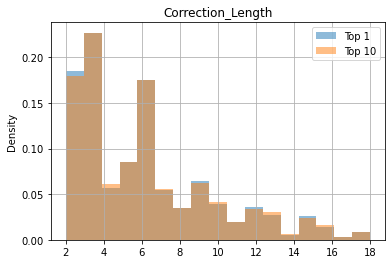

In [874]:
import matplotlib.pyplot as plt
selected_pegRNAs_combined["Correction_Length"].hist(bins=17, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["Correction_Length"].hist(bins=17, density=True, alpha=0.5, label="Top 10")
plt.title("Correction_Length")
plt.ylabel("Density")
plt.legend()


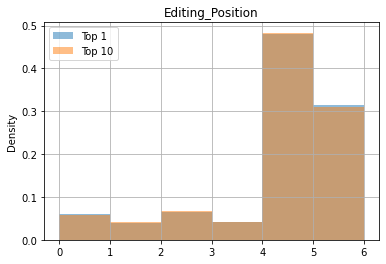

In [875]:
selected_pegRNAs_combined["Editing_Position"].hist(bins=6, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["Editing_Position"].hist(bins=6, density=True, alpha=0.5, label="Top 10")
plt.title("Editing_Position")
plt.ylabel("Density")
plt.legend()

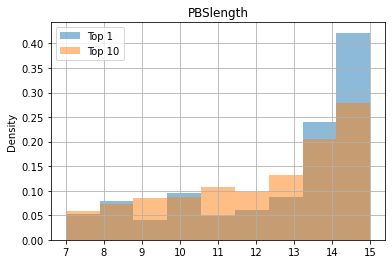

In [876]:
selected_pegRNAs_combined["PBSlength"].hist(bins=9, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["PBSlength"].hist(bins=9, density=True, alpha=0.5, label="Top 10")
plt.title("PBSlength")
plt.ylabel("Density")
plt.legend()

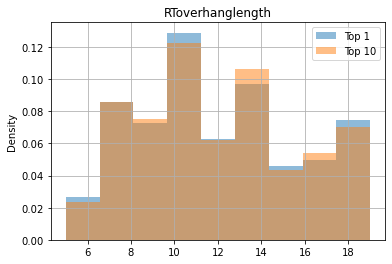

In [877]:
selected_pegRNAs_combined["RToverhanglength"].hist(bins=9, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["RToverhanglength"].hist(bins=9, density=True, alpha=0.5, label="Top 10")
plt.title("RToverhanglength")
plt.ylabel("Density")
plt.legend()

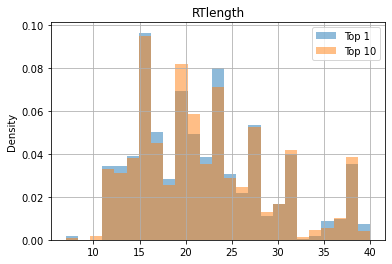

In [878]:
selected_pegRNAs_combined["RTlength"].hist(bins=25, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["RTlength"].hist(bins=25, density=True, alpha=0.5, label="Top 10")
plt.title("RTlength")
plt.ylabel("Density")
plt.legend()

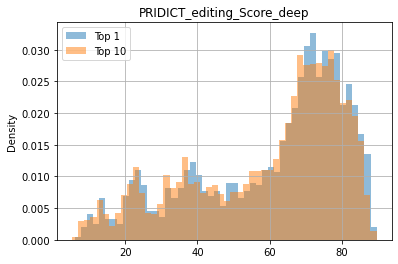

In [879]:
selected_pegRNAs_combined["PRIDICT_editing_Score_deep"].hist(bins=50, density=True, alpha=0.5, label="Top 1")
final_pegRNAs_selected_df_detailed["PRIDICT_editing_Score_deep"].hist(bins=50, density=True, alpha=0.5, label="Top 10")
plt.title("PRIDICT_editing_Score_deep")
plt.ylabel("Density")
plt.legend()

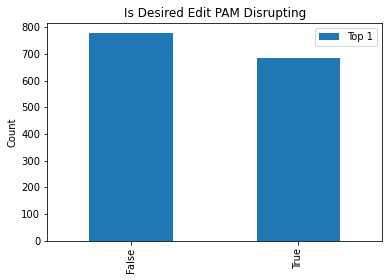

In [889]:
selected_pegRNAs_combined["is_edit_pam_disrupting"].value_counts().plot(kind='bar', label="Top 1")
plt.title("Is Desired Edit PAM Disrupting")
plt.ylabel("Count")
plt.legend()
plt.show()

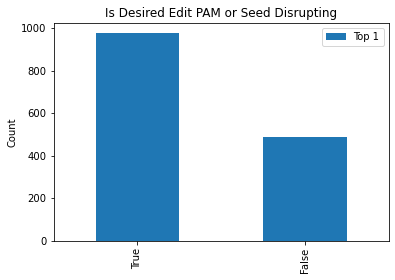

In [891]:
(selected_pegRNAs_combined["is_edit_pam_disrupting"] | selected_pegRNAs_combined["is_edit_seed_disrupting"]).value_counts().plot(kind='bar', label="Top 1")
plt.title("Is Desired Edit PAM or Seed Disrupting")
plt.ylabel("Count")
plt.legend()
plt.show()

In [894]:
selected_pegRNAs_combined.to_csv('20221228_selected_pegRNAs_combined.tsv', sep="\t")

In [ ]:
# TODO 20221228 There are some in the spreadsheet that is not ranked #1. 

### Validation of spreadsheet

Work in progress

In [895]:
selected_pegRNAs_combined

,Original_Sequence,Edited-Sequences,Target-Strand,Mutation_Type,Correction_Type,Correction_Length,Editing_Position,PBSlength,RToverhanglength,RTlength,...,mutated_codon_sequence,original_synonymous_mutation,mutated_synonymous_mutation,is_edit_pam_disrupting,is_edit_seed_disrupting,pegRNA_orientation,hamming,protospacers_with_pam,sequence_swap,pridict_sequence
0,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,11,6,13,...,GCT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/CT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
10,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,3,4,12,6,13,...,TGT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GGC/TGT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
20,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,GAT,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/AT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
30,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,5,12,6,13,...,GAA,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GC/AA,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
40,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...,Fw,MultibpReplacement,Replacement,2,4,12,7,13,...,TTC,NaN,NaN,True,False,+,2,"[('TCAGACCGGGACTGCTTGGACGG', -1, True)]",GG/TT,TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGAT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14560,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,3,3,9,9,15,...,AGA,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",TGG/AGA,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14570,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,2,4,11,9,15,...,TCT,NaN,NaN,True,False,+,2,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",GG/CT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14580,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,3,3,11,9,15,...,ACT,NaN,NaN,True,False,+,3,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",TGG/ACT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...
14590,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...,Fw,MultibpReplacement,Replacement,3,3,12,9,15,...,GTT,NaN,NaN,True,False,+,3,"[('GCGAGTGCATCCACTCCAGCTGG', 0, True)]",TGG/GTT,GCCGCAGCGCTGTAGGGGTCTTTACGTGTTCCAAGGGGACAGTAGC...


Seq('TTGGGAGACTTCACACGGTGATGGTGGTCTCGGCCCATCCATCCCTGCAGCCCC...TGG')

In [902]:
selected_pegRNAs_combined.iloc[0,0] in coding_tiling_sequence.complete_sequence

'TGCAGCCCCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGATGGGAAGTGCATCTCTCGGCAGTTCGTCTGTGACTCAGACCGGGACTGCTTGGACGGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACC'

In [912]:
selected_pegRNAs_combined.iloc[0,0] in coding_tiling_sequence.complete_sequence

True

In [910]:
[codon.sequence for codon in coding_tiling_sequence.coding_codon_set]

[Codon(sequence_codon_index=0, genome_index_start=0, genome_index_stop=3, codon_sequence=Seq('CCC')),
 Codon(sequence_codon_index=1, genome_index_start=3, genome_index_stop=6, codon_sequence=Seq('AAG')),
 Codon(sequence_codon_index=2, genome_index_start=6, genome_index_stop=9, codon_sequence=Seq('ACG')),
 Codon(sequence_codon_index=3, genome_index_start=9, genome_index_stop=12, codon_sequence=Seq('TGC')),
 Codon(sequence_codon_index=4, genome_index_start=12, genome_index_stop=15, codon_sequence=Seq('TCC')),
 Codon(sequence_codon_index=5, genome_index_start=15, genome_index_stop=18, codon_sequence=Seq('CAG')),
 Codon(sequence_codon_index=6, genome_index_start=18, genome_index_stop=21, codon_sequence=Seq('GAC')),
 Codon(sequence_codon_index=7, genome_index_start=21, genome_index_stop=24, codon_sequence=Seq('GAG')),
 Codon(sequence_codon_index=8, genome_index_start=24, genome_index_stop=27, codon_sequence=Seq('TTT')),
 Codon(sequence_codon_index=9, genome_index_start=27, genome_index_stop

In [915]:
coding_start_coordinate = coding_tiling_sequence.coding_coordinates[0]

In [914]:
pegRNA_start_coordinate = coding_tiling_sequence.complete_sequence.find(selected_pegRNAs_combined.iloc[0,0])

In [916]:
pegRNA_start_coordinate

45

In [917]:
coding_start_coordinate

52

7

In [919]:
selected_pegRNAs_combined.iloc[0,0][coding_start_coordinate-pegRNA_start_coordinate:]

'CCCAAGACGTGCTCCCAGGACGAGTTTCGCTGCCACGATGGGAAGTGCATCTCTCGGCAGTTCGTCTGTGACTCAGACCGGGACTGCTTGGACGGCTCAGACGAGGCCTCCTGCCCGGTGCTCACCTGTGGTCCCGCCAGCTTCCAGTGCAACAGCTCCACCTGCATCCCCCAGCTGTGGGCCTGCGACAACGACC'

In [ ]:
coding_tiling_sequence.coding